# Weather Regimes
1. Explore CGrams Files
2. Port file io functions to R.

In [35]:
source("../RScripts/config.r")
source("../RScripts/plot_functions.r")
source("../RScripts/data_functions.r")
source("../RScripts/algo_functions.r")


options(repr.plot.width = 15, repr.plot.height = 10) # Adjust width & height


In [37]:
result <- wrera(
    start = "19500111_00",
    end = "20250113_21",
    hours = c("00", "06", "12", "18"),
    tformat = "string",
    setup = "z500anom_1979_2019_on_wrdef_10d_1.0_1979_2019",
    dataset = "era5",
    basepath = "../WR_read_example_package/wr_era5_update_1950_latwgt/"
)

wr_df <- result$data$LC %>%
    filter(grepl("12$", time))
wr_df$date <- as.Date(wr_df$time, format = "%Y%m%d_%H")
tail(wr_df)


tsince time        wrindex wrname date      
1 403428 20250108_12 3       GL     2025-01-08
2 403452 20250109_12 3       GL     2025-01-09
3 403476 20250110_12 3       GL     2025-01-10
4 403500 20250111_12 0       no     2025-01-11
5 403524 20250112_12 0       no     2025-01-12
6 403548 20250113_12 0       no     2025-01-13

In [4]:
prop.table(table(wr_df$wrname))



        AR         AT       EuBL         GL         no       ScBL       ScTr 
0.09552141 0.09183487 0.09628791 0.10559550 0.31780852 0.10048545 0.10687302 
        ZO 
0.08559331 

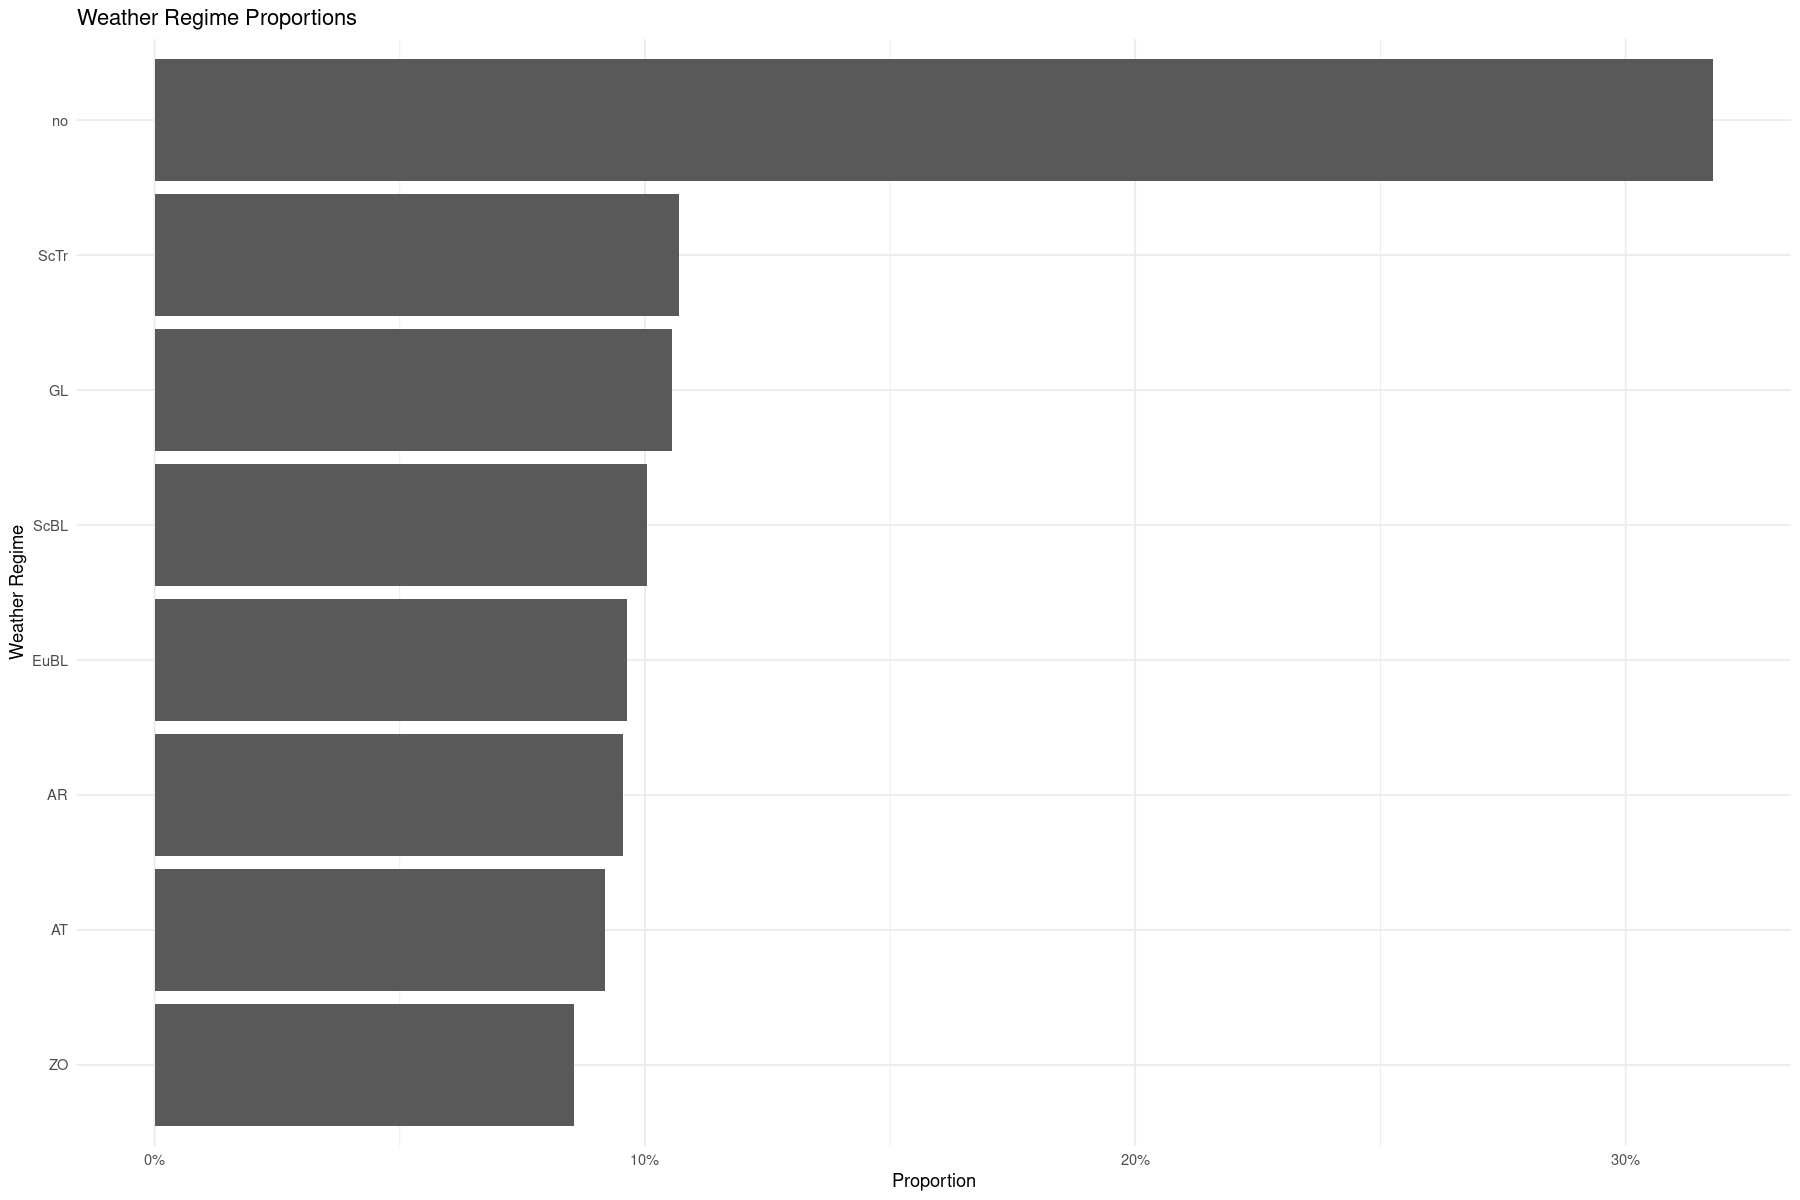

In [5]:
result$data$LC %>%
    filter(grepl("12$", time)) %>%
    group_by(wrname) %>%
    summarise(n = n()) %>%
    arrange(desc(n)) %>%
    mutate(prop = n / sum(n)) %>%
    ungroup() %>%
    mutate(wrname = factor(wrname, levels = rev(wrname))) %>%
    ggplot(aes(x = wrname, y = prop)) +
    geom_col() +
    coord_flip() +
    scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
    labs(
        x = "Weather Regime",
        y = "Proportion",
        title = "Weather Regime Proportions"
    ) +
    theme_minimal()


# Do some composites
1. Get time series of WRs (see above)
2. write a function get_composite_df, which
    1. takes WR time series, (S)LM_DIR
    2. cycles through WRs
        1. for each WR select dates
        2. for each grid point average residuals
    3. returns a df with columns lat, lon, WR, value
3. estimate significance through permutation test
4. plot using plot_spatial (adjust if necessary)
5. add contours of the WR (adjust if necessary)

In [6]:
# comp_df <- calculate_composite_values(
#     df = wr_df,
#     lm_dir = LM_DIR
# )
# saveRDS(comp_df, "../ens_data/composites.RDS")

comp_df <- readRDS("../ens_data/composites_permuted.RDS")

comp_df <- comp_df %>% mutate(p_value_adj = p.adjust(p_value, method = "fdr"))
head(comp_df)
str(comp_df)


wr wrname mean         p_value lon lat p_value_adj
1 0  no     -0.006291271 0.3866  -1  20  0.5432699  
2 1  AT      0.009113813 0.5516  -1  20  0.6972149  
3 2  AR     -0.029496106 0.0523  -1  20  0.1142518  
4 3  GL     -0.008186473 0.5739  -1  20  0.7150782  
5 4  EuBL    0.007755896 0.6103  -1  20  0.7445849  
6 5  ScBL    0.014852727 0.3218  -1  20  0.4748308

tibble [68,728 × 7] (S3: tbl_df/tbl/data.frame)
 $ wr         : int [1:68728] 0 1 2 3 4 5 6 7 0 1 ...
 $ wrname     : chr [1:68728] "no" "AT" "AR" "GL" ...
 $ mean       : num [1:68728] -0.00629 0.00911 -0.0295 -0.00819 0.00776 ...
 $ p_value    : num [1:68728] 0.3866 0.5516 0.0523 0.5739 0.6103 ...
 $ lon        : num [1:68728] -1 -1 -1 -1 -1 -1 -1 -1 -10 -10 ...
 $ lat        : num [1:68728] 20 20 20 20 20 20 20 20 20 20 ...
 $ p_value_adj: num [1:68728] 0.543 0.697 0.114 0.715 0.745 ...


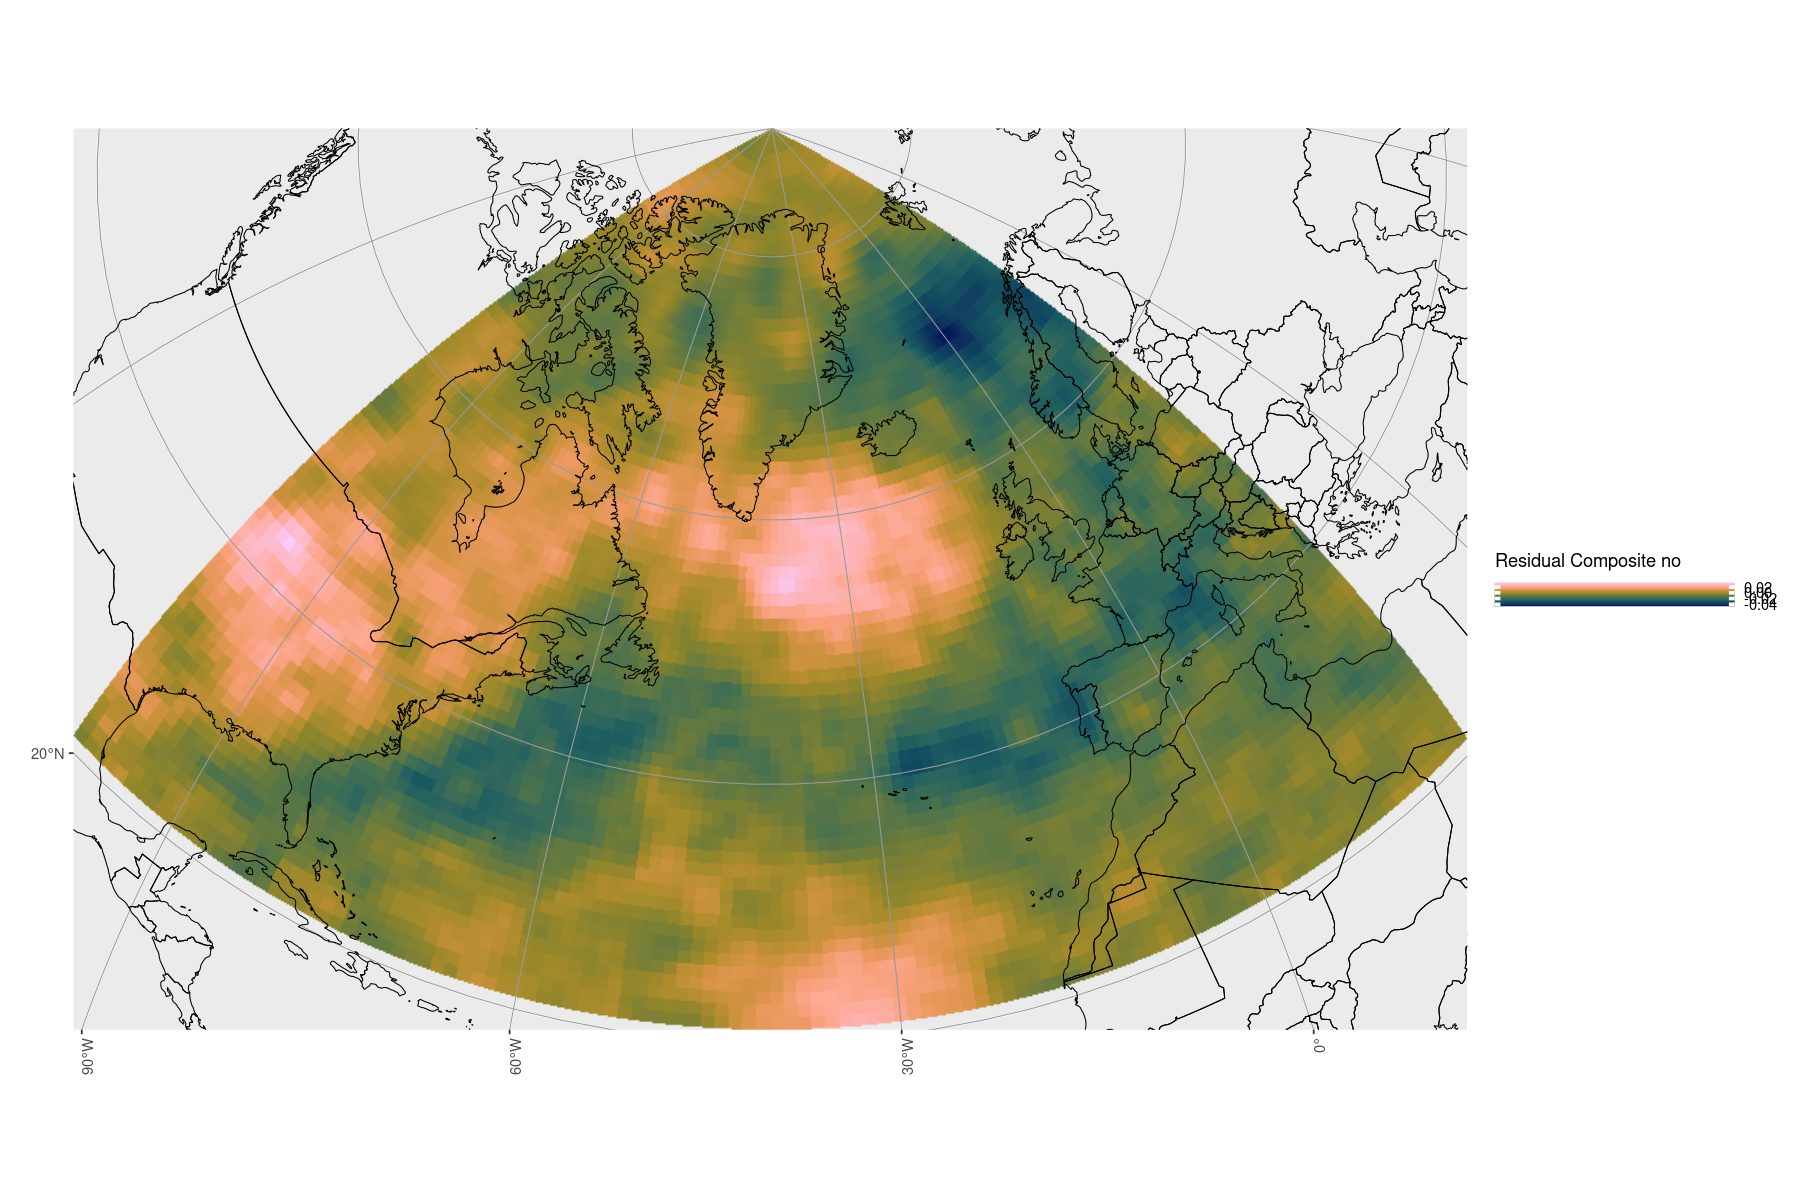

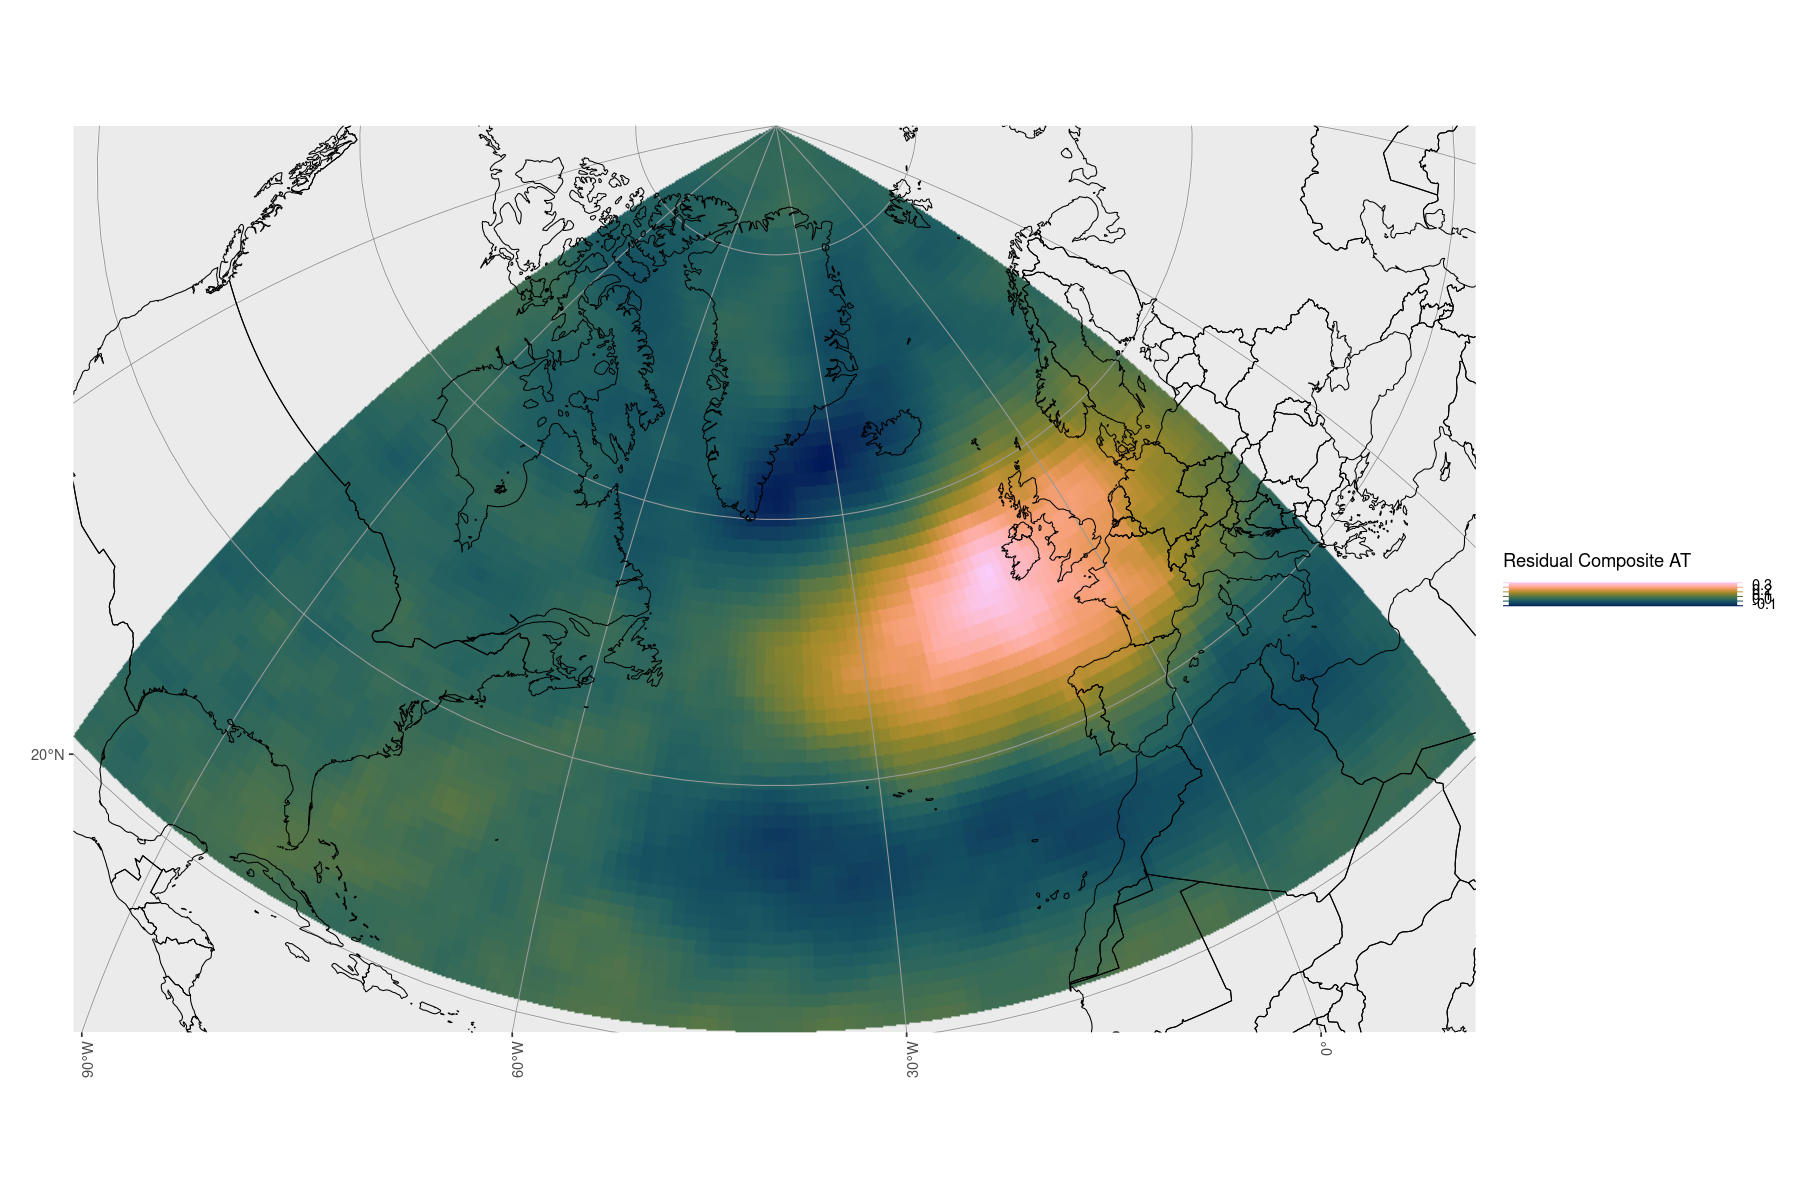

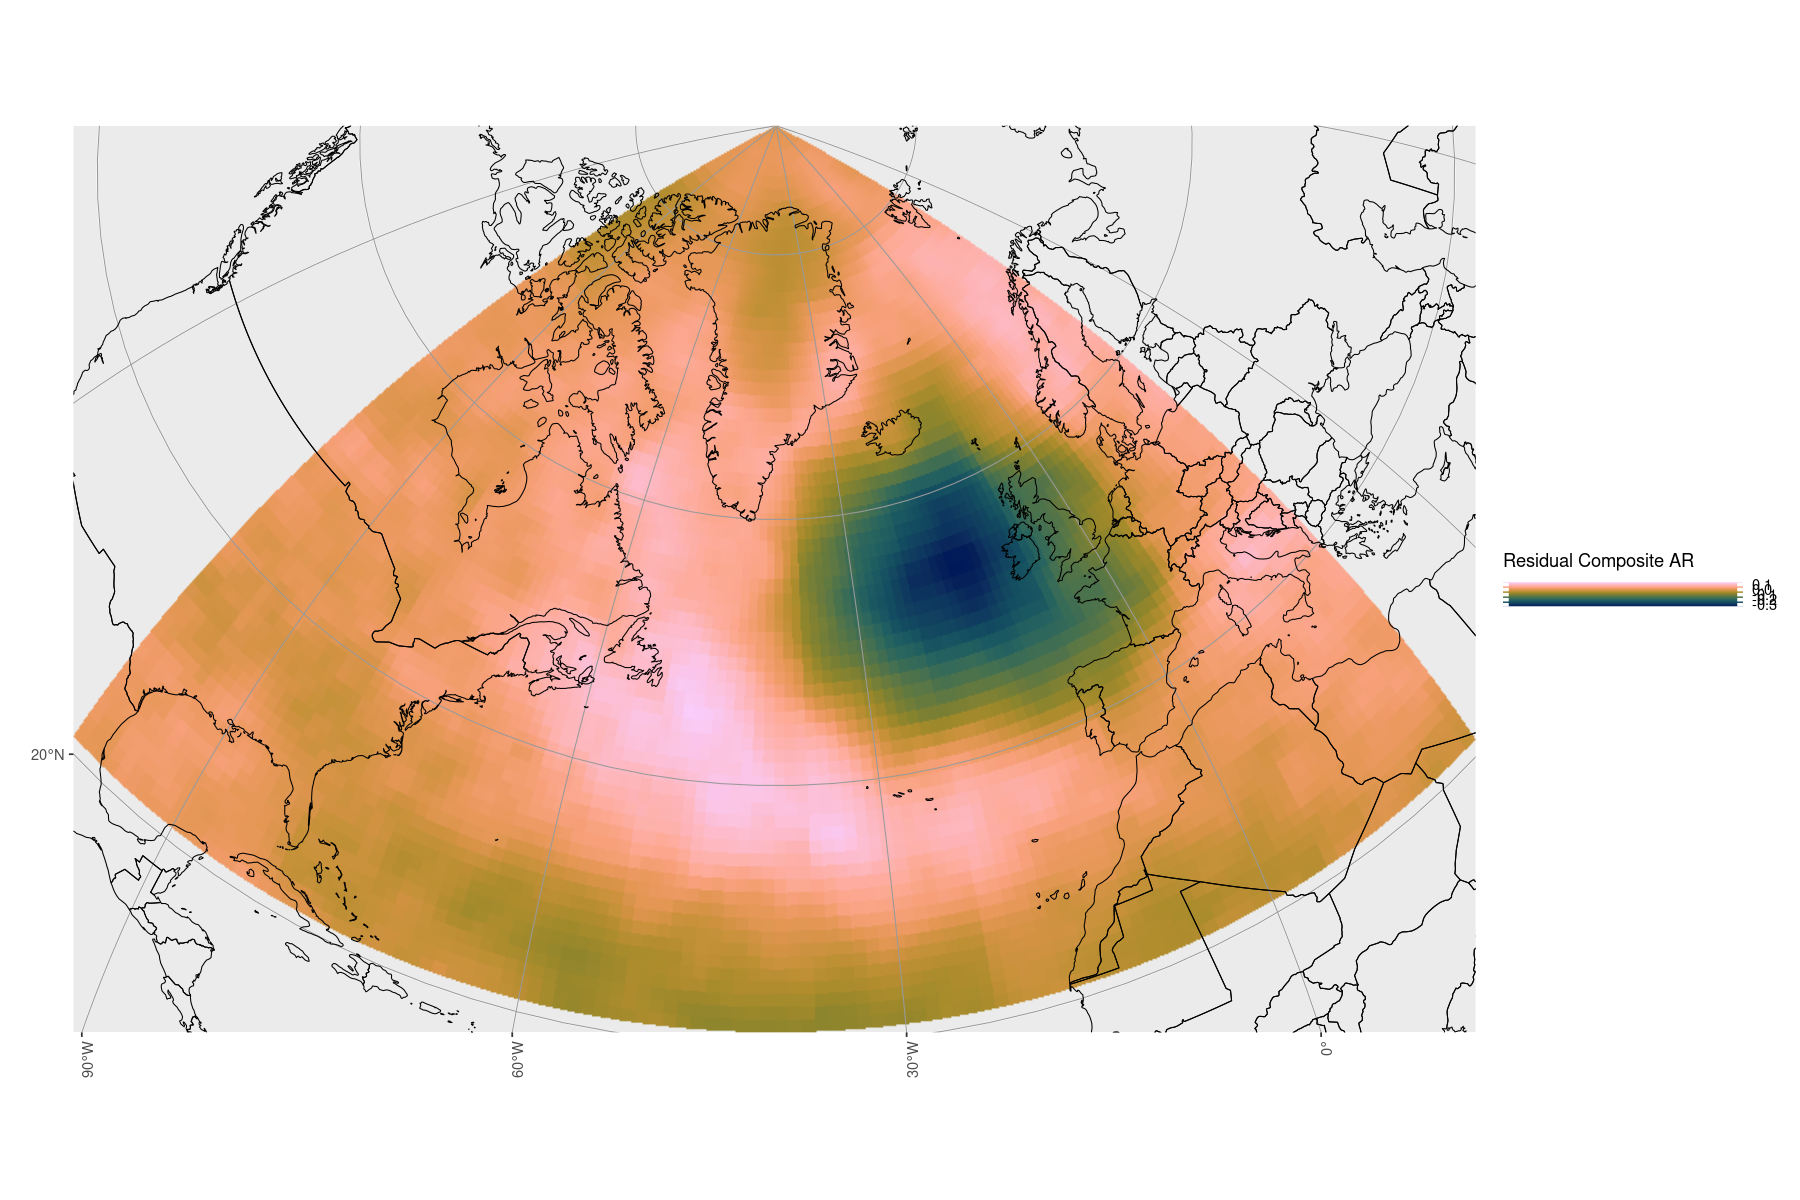

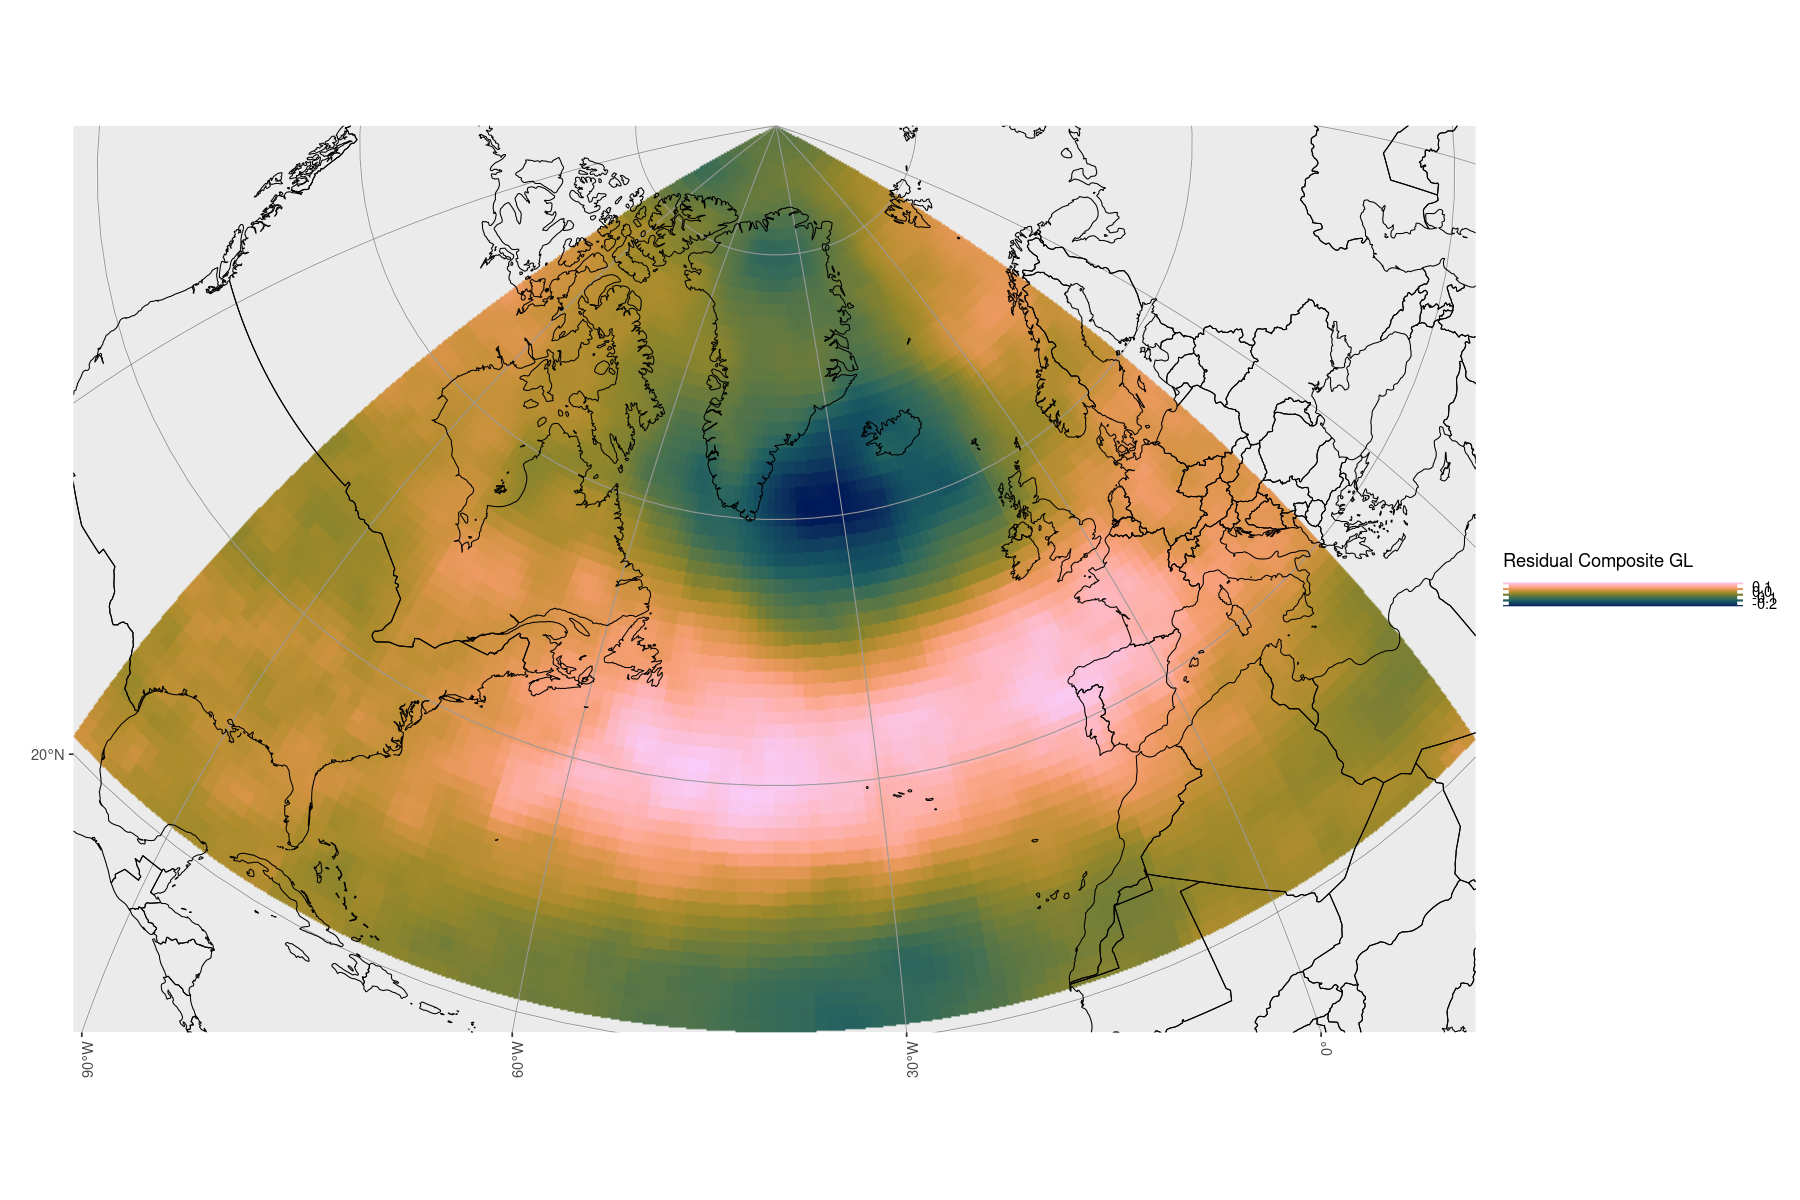

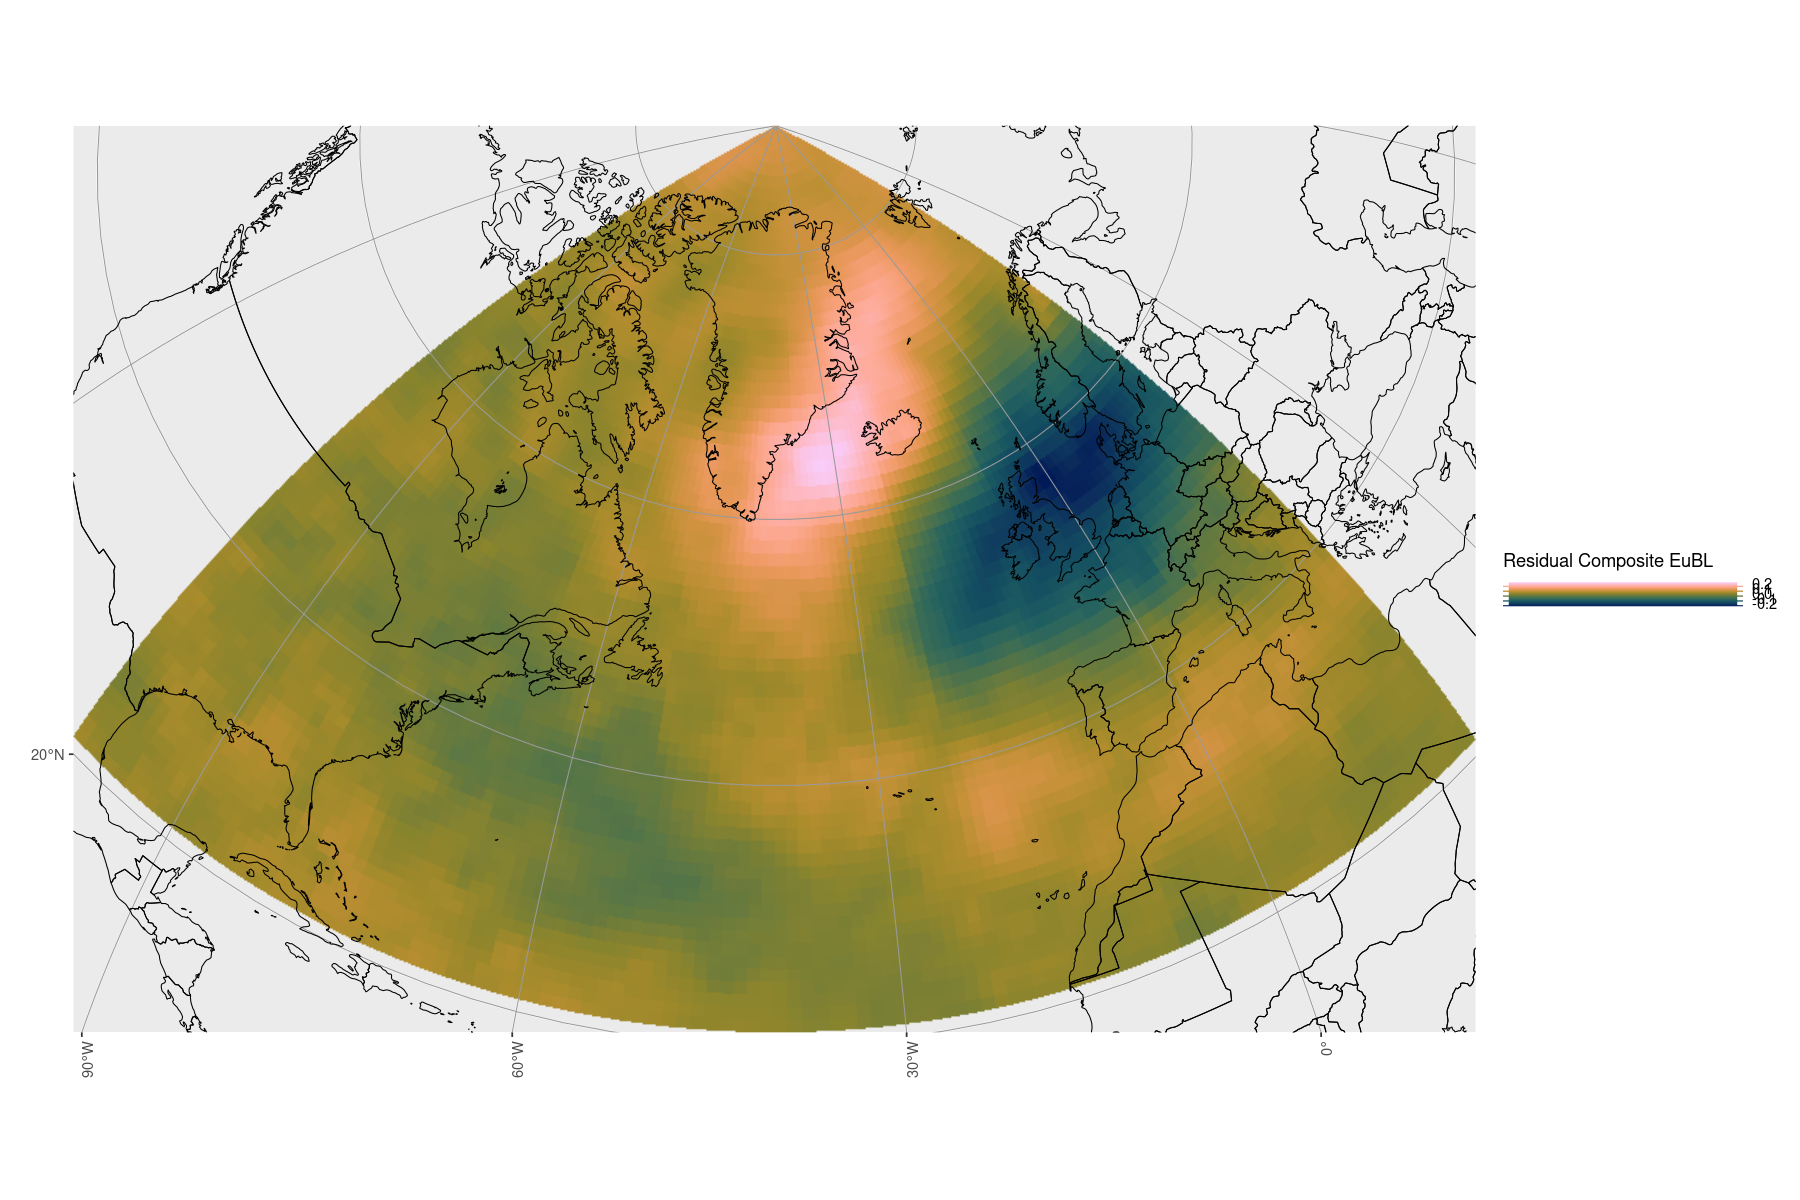

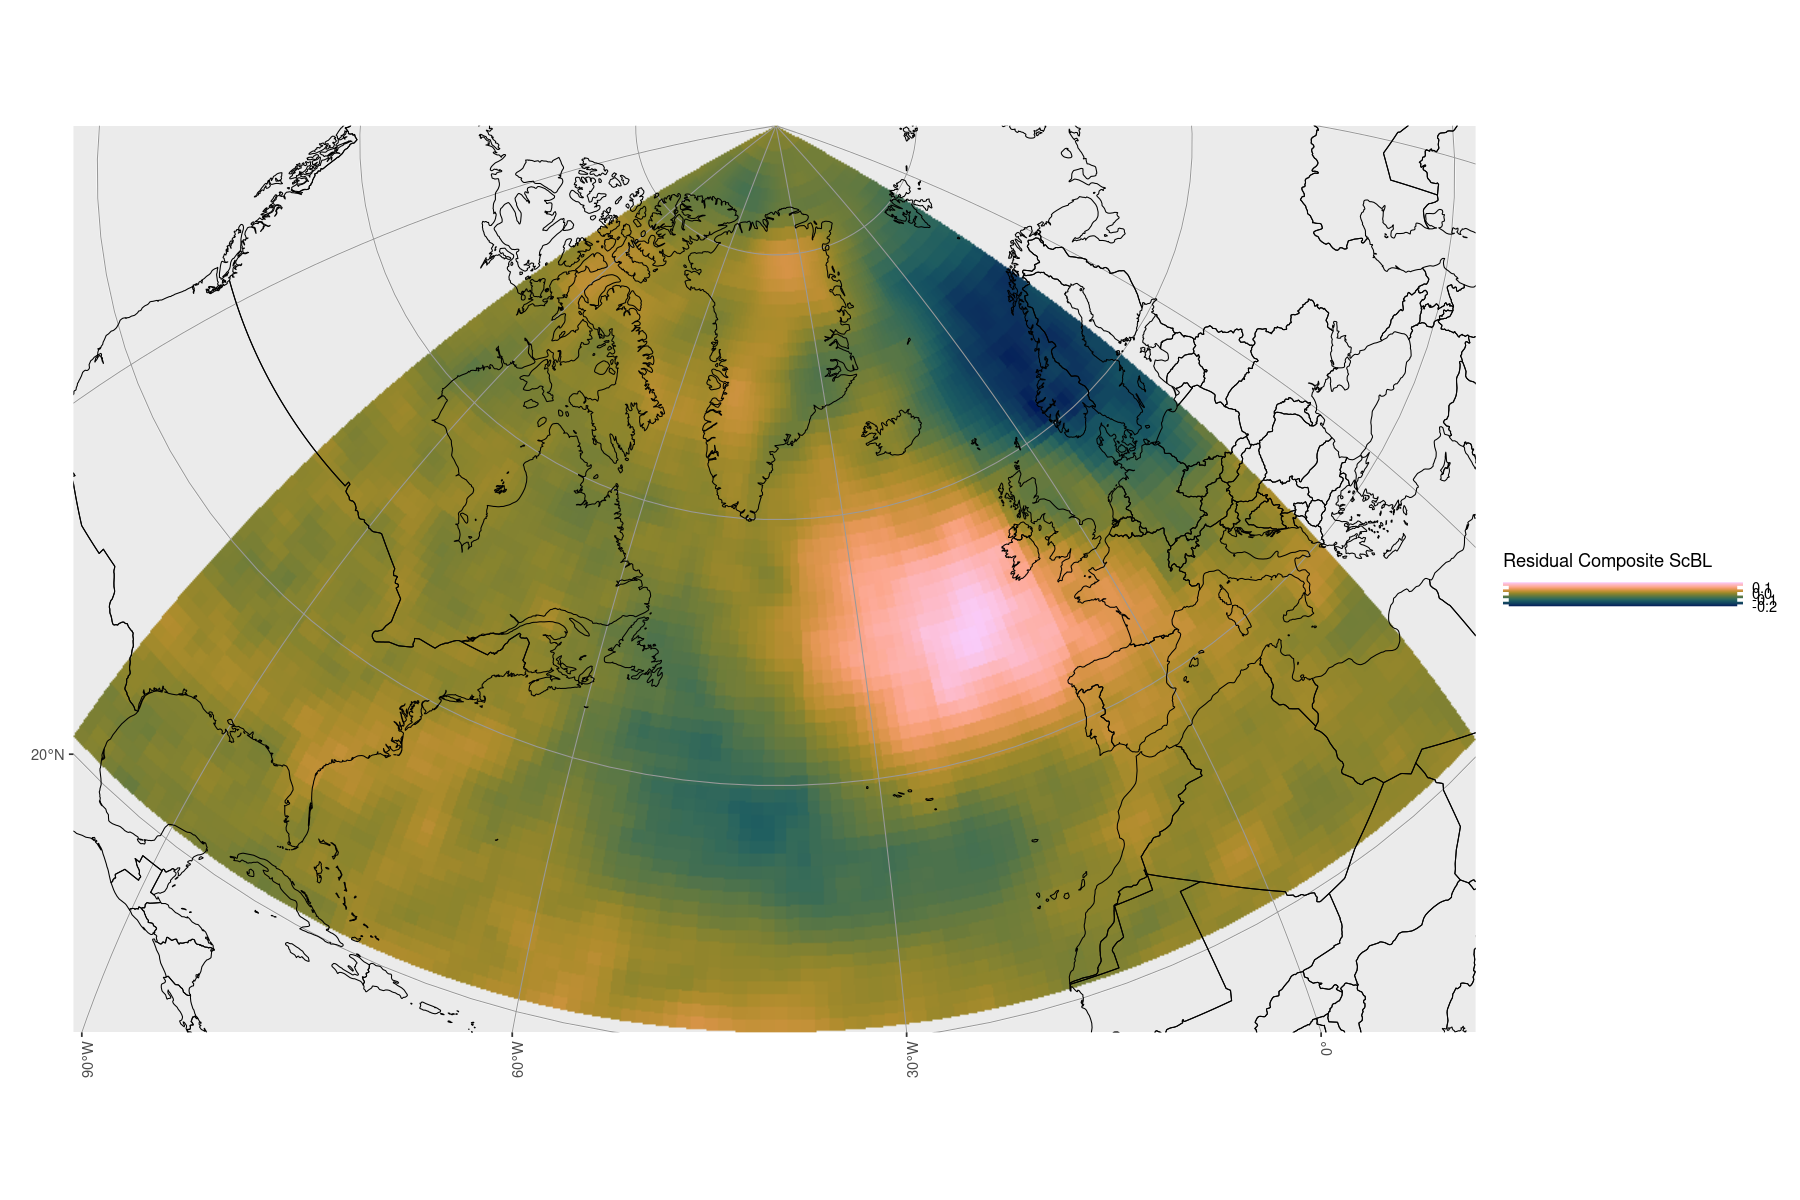

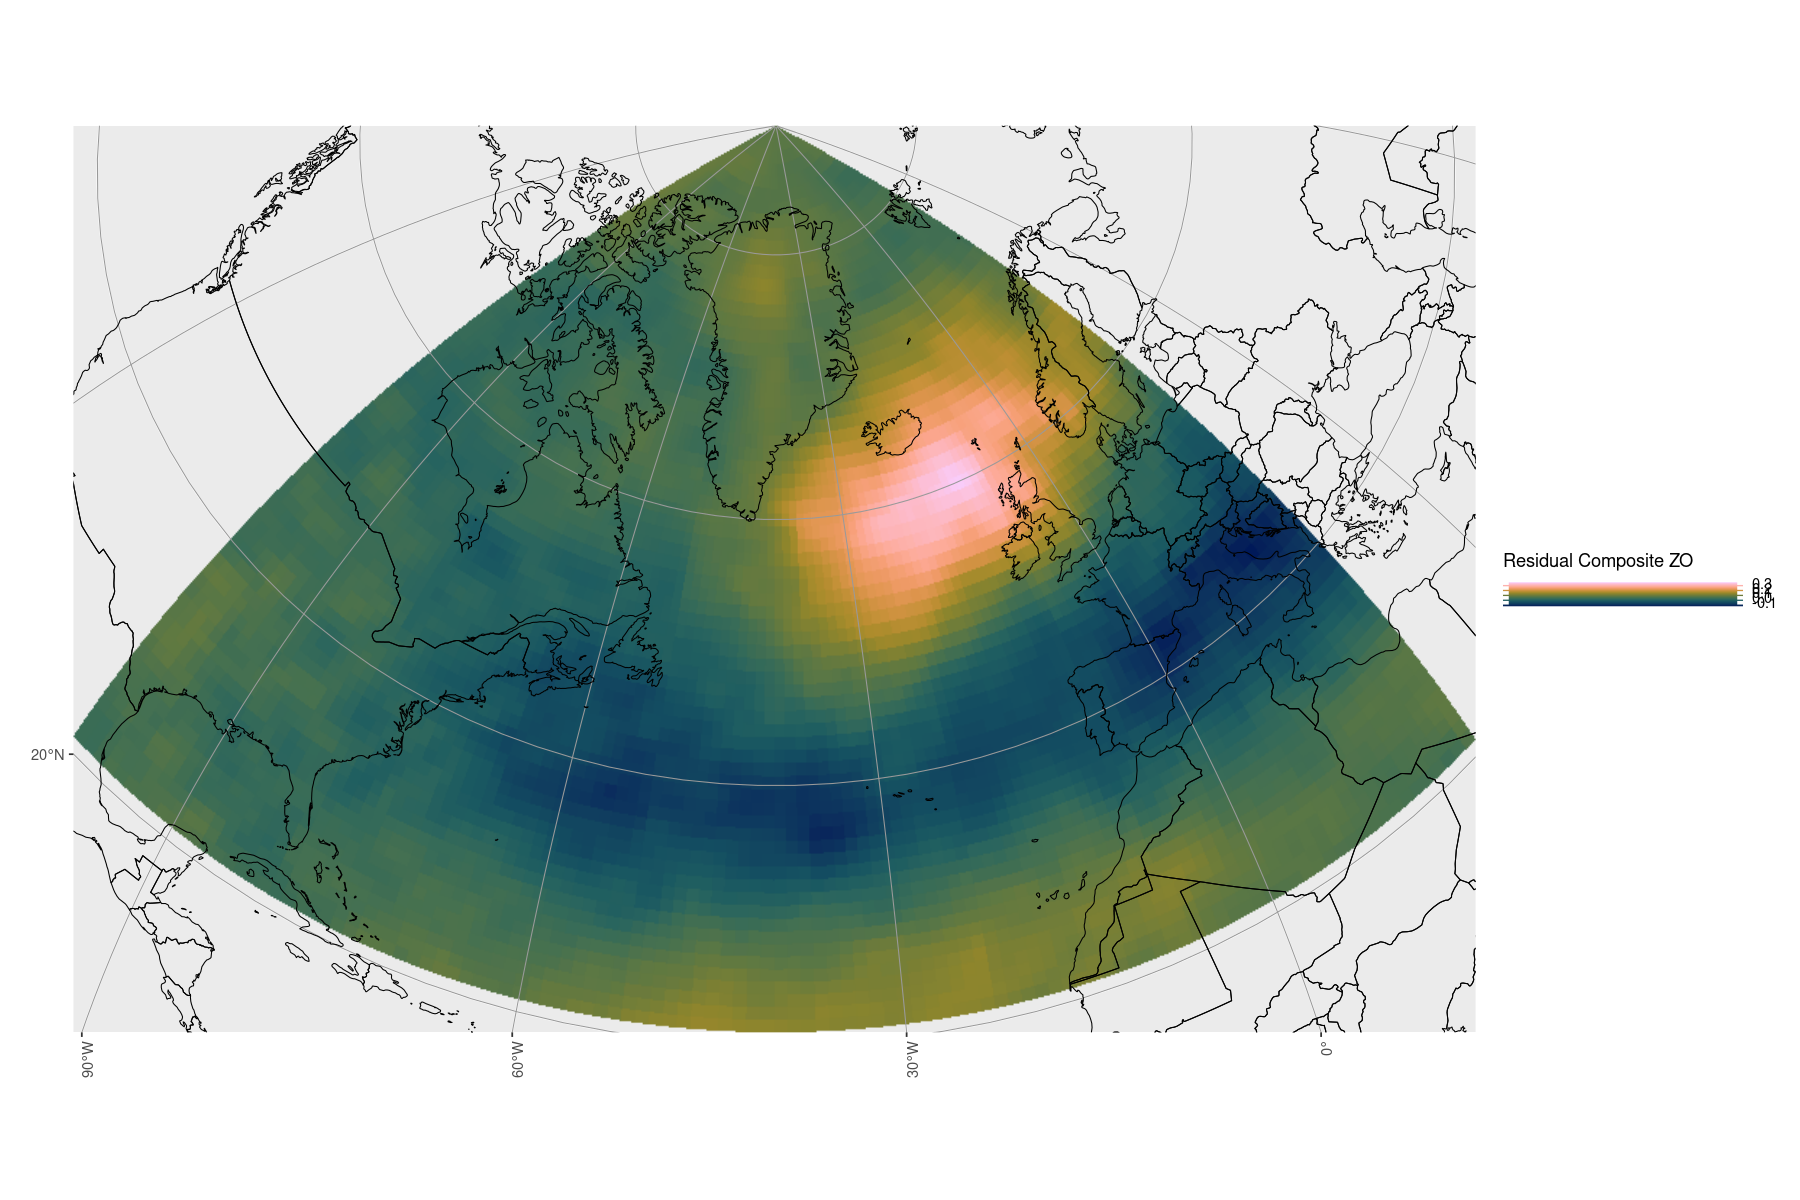

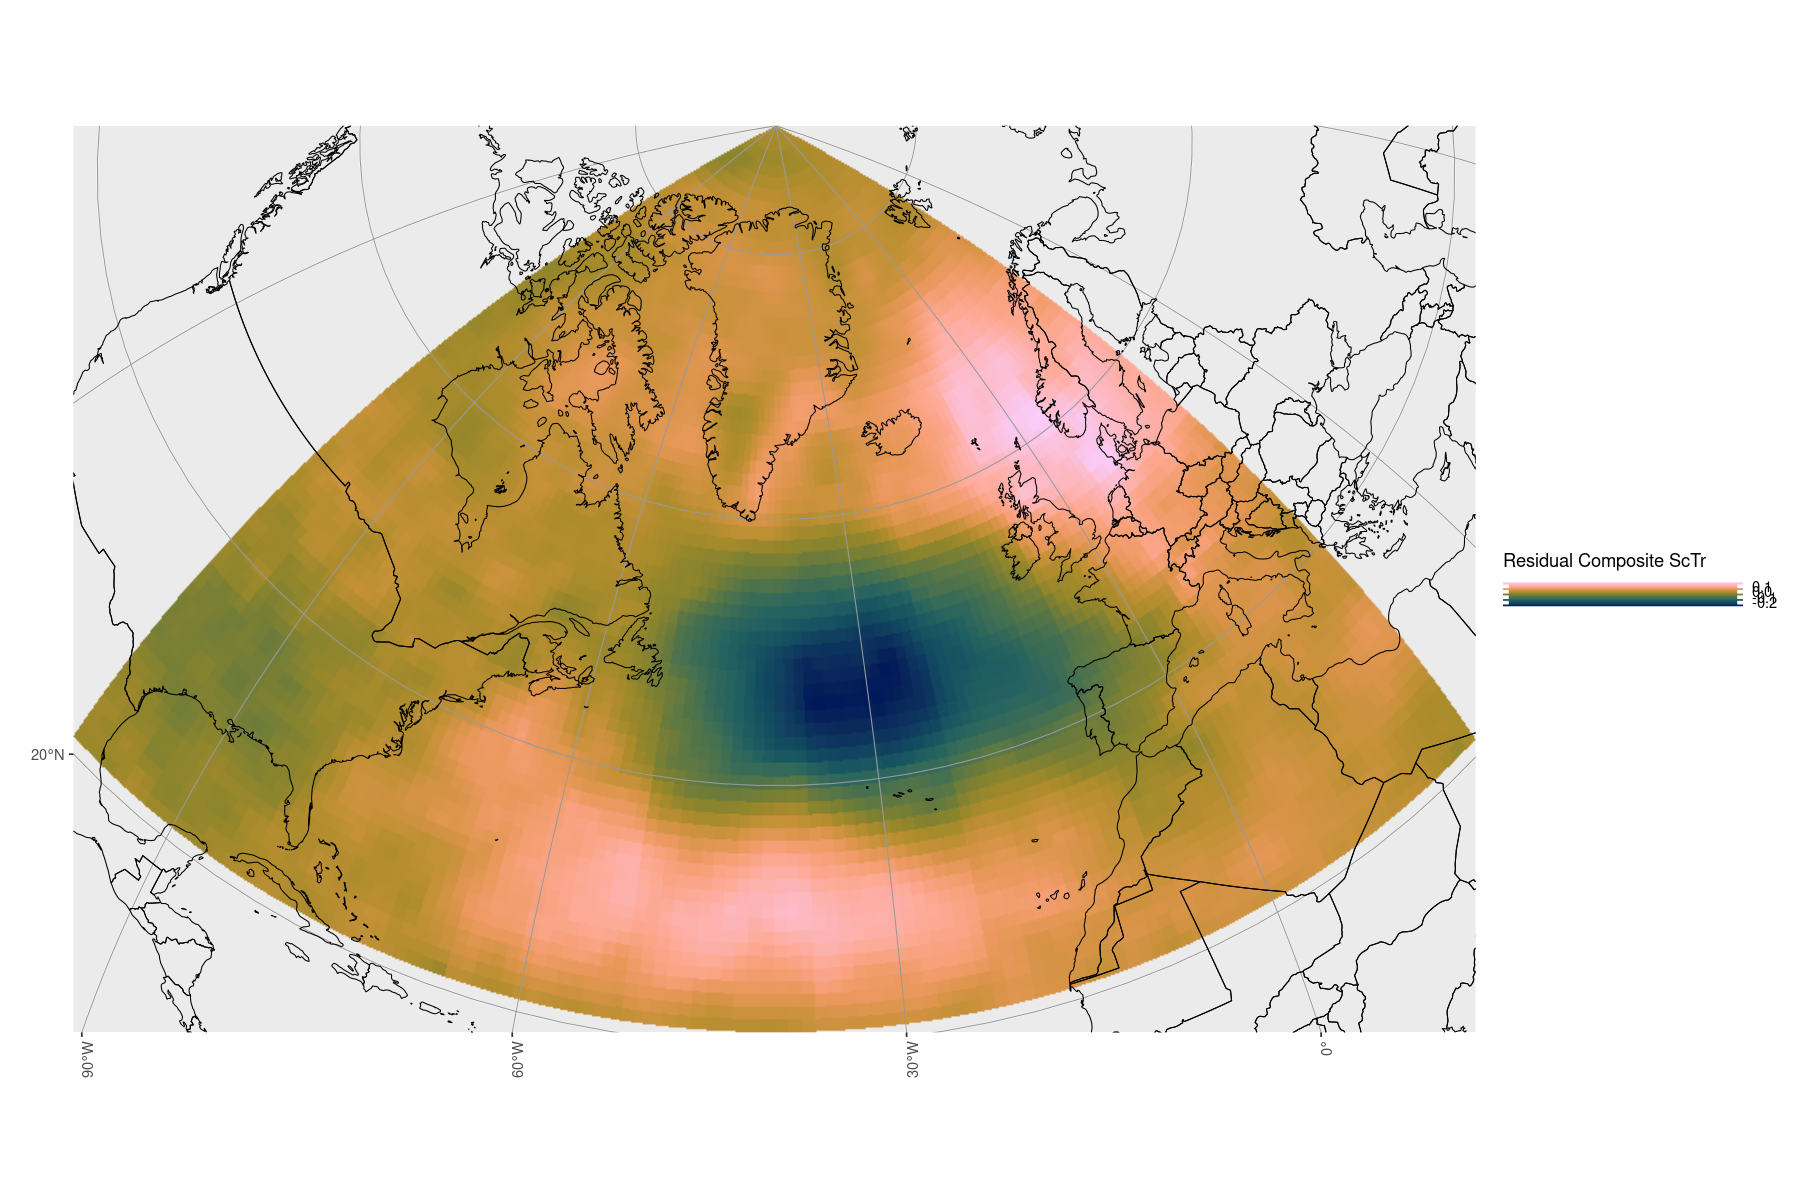

In [7]:
for (wrn in unique(comp_df$wrname)) {
    wr_df_i <- comp_df %>%
        filter(wrname == wrn)
    # Plotting the mean
    p <- plot_spatial(wr_df_i, "mean",
        legend_name = paste0("Residual Composite ", wrn)
    )
    print(p)
}


# Now with permutation test

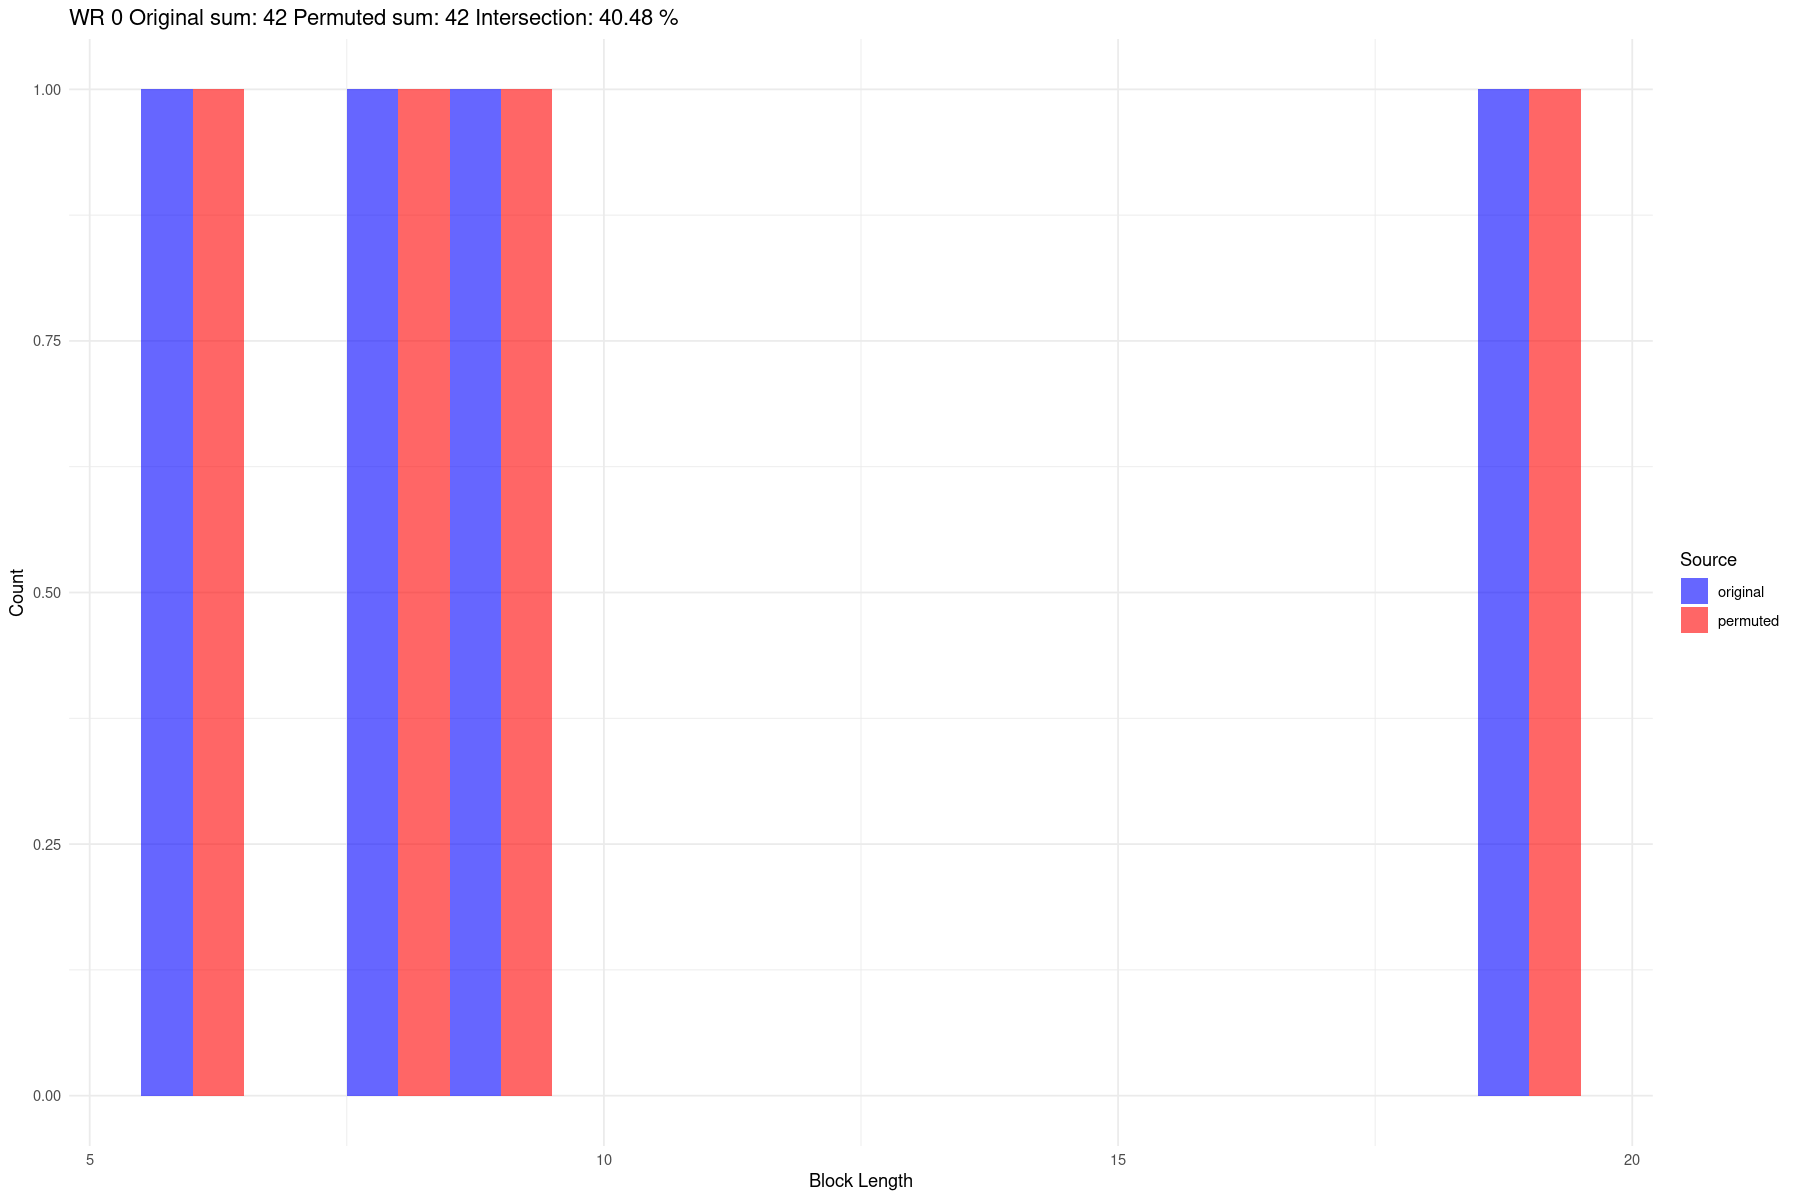

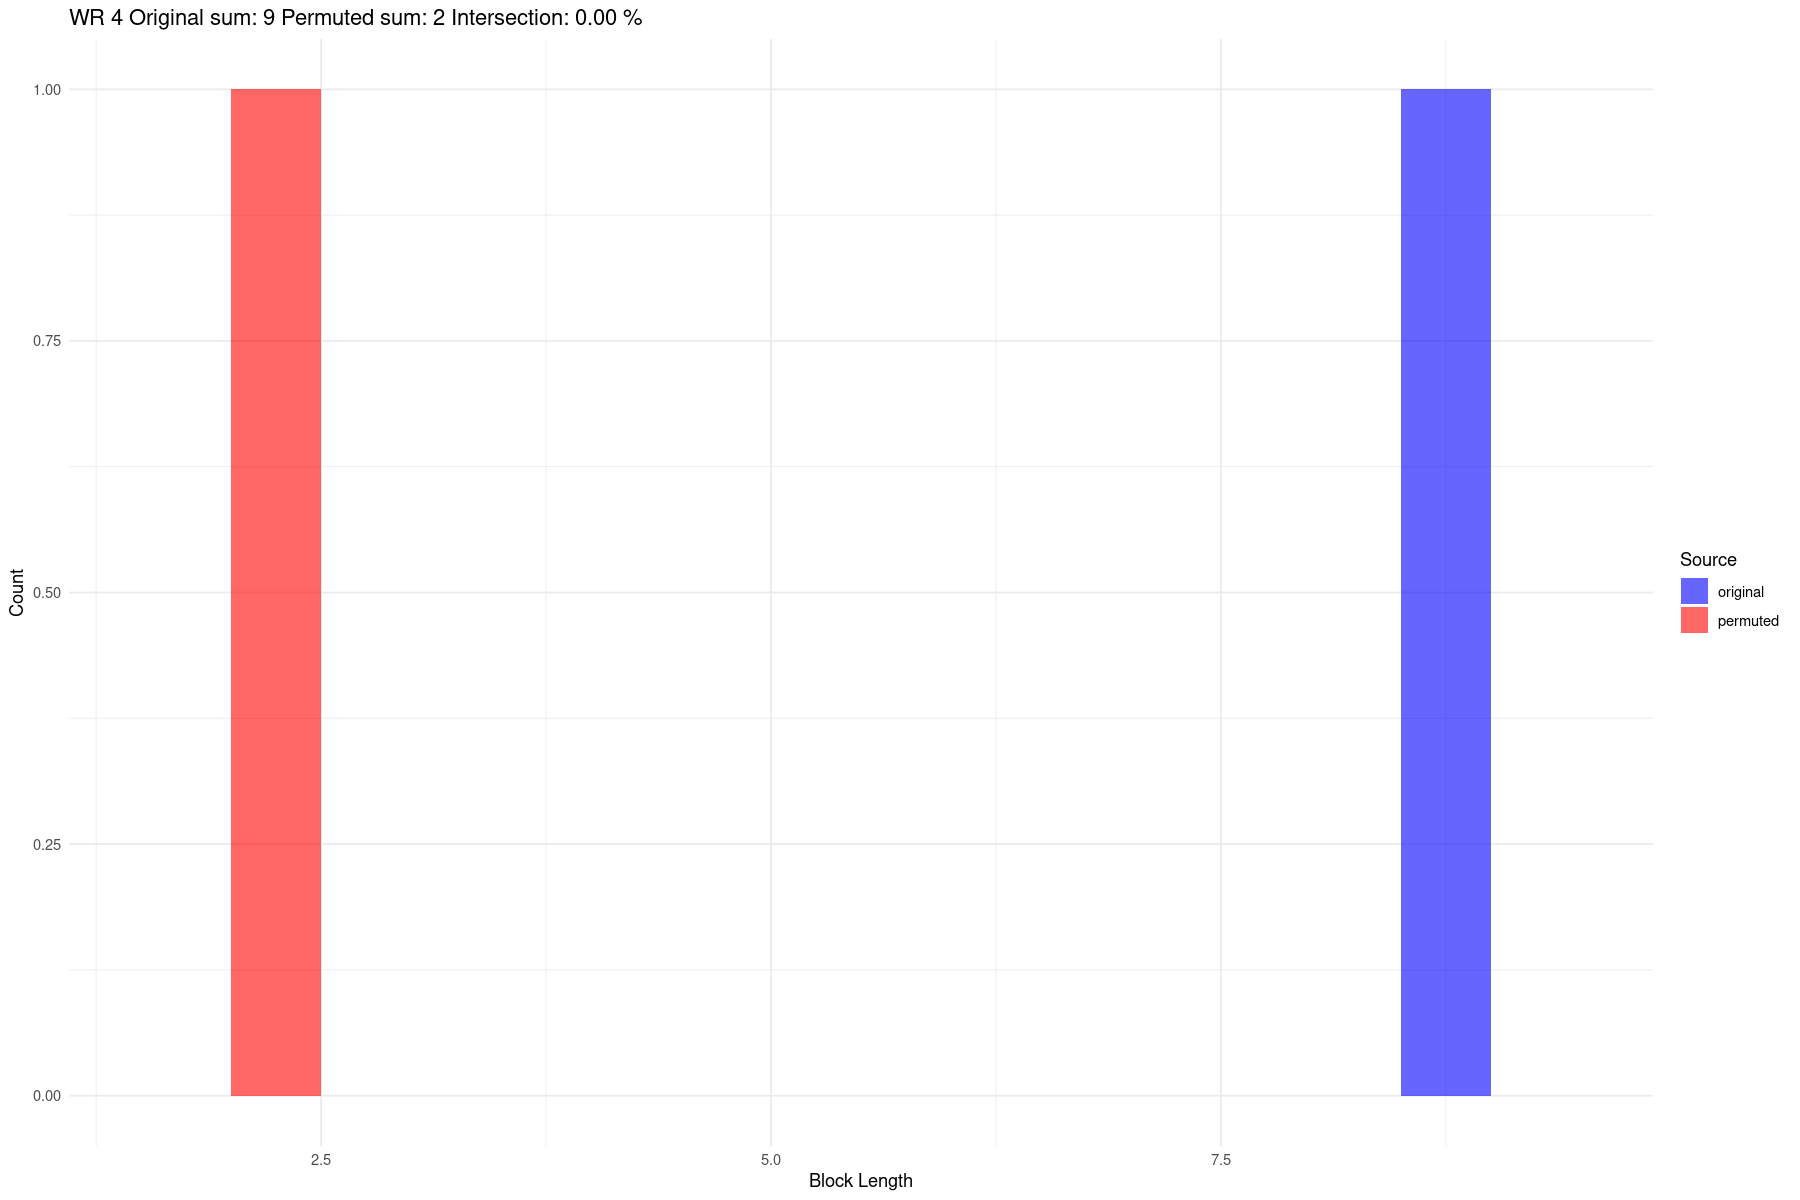

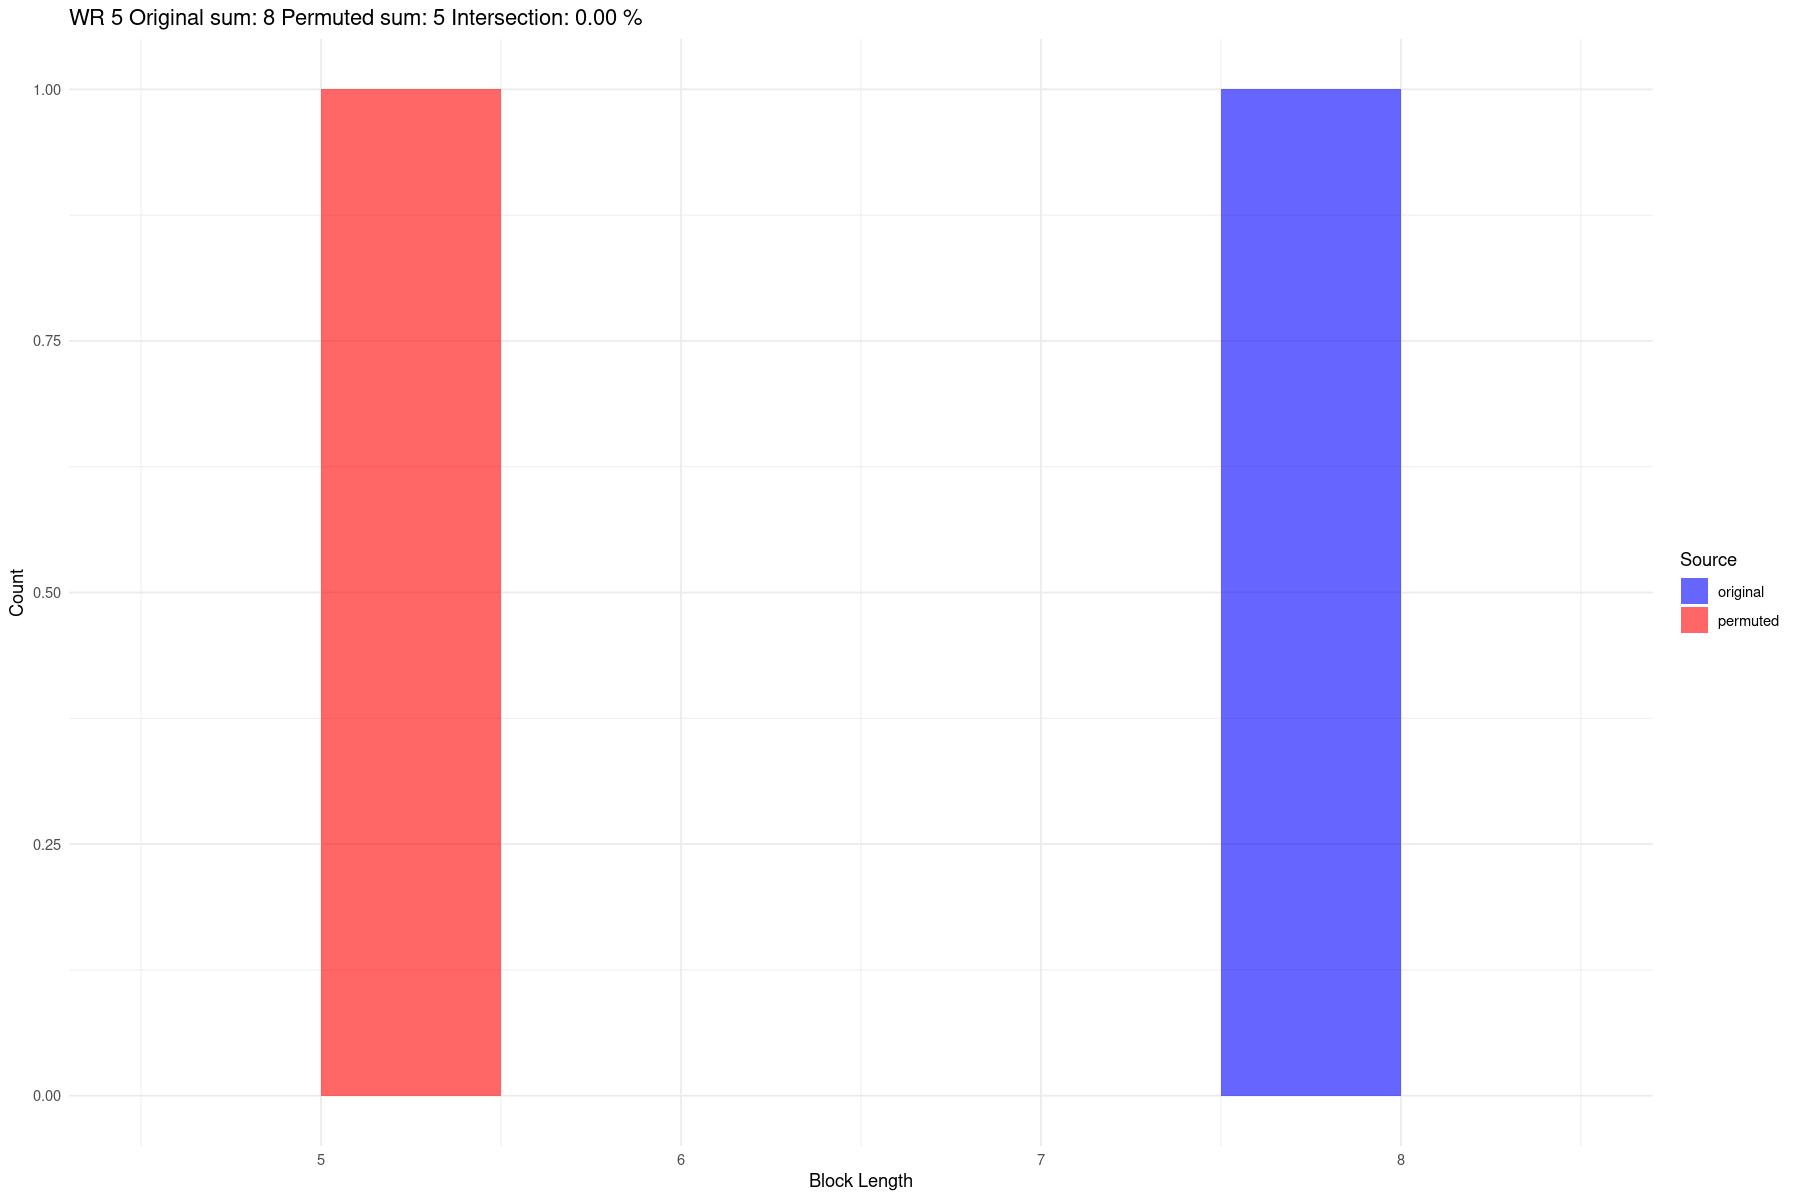

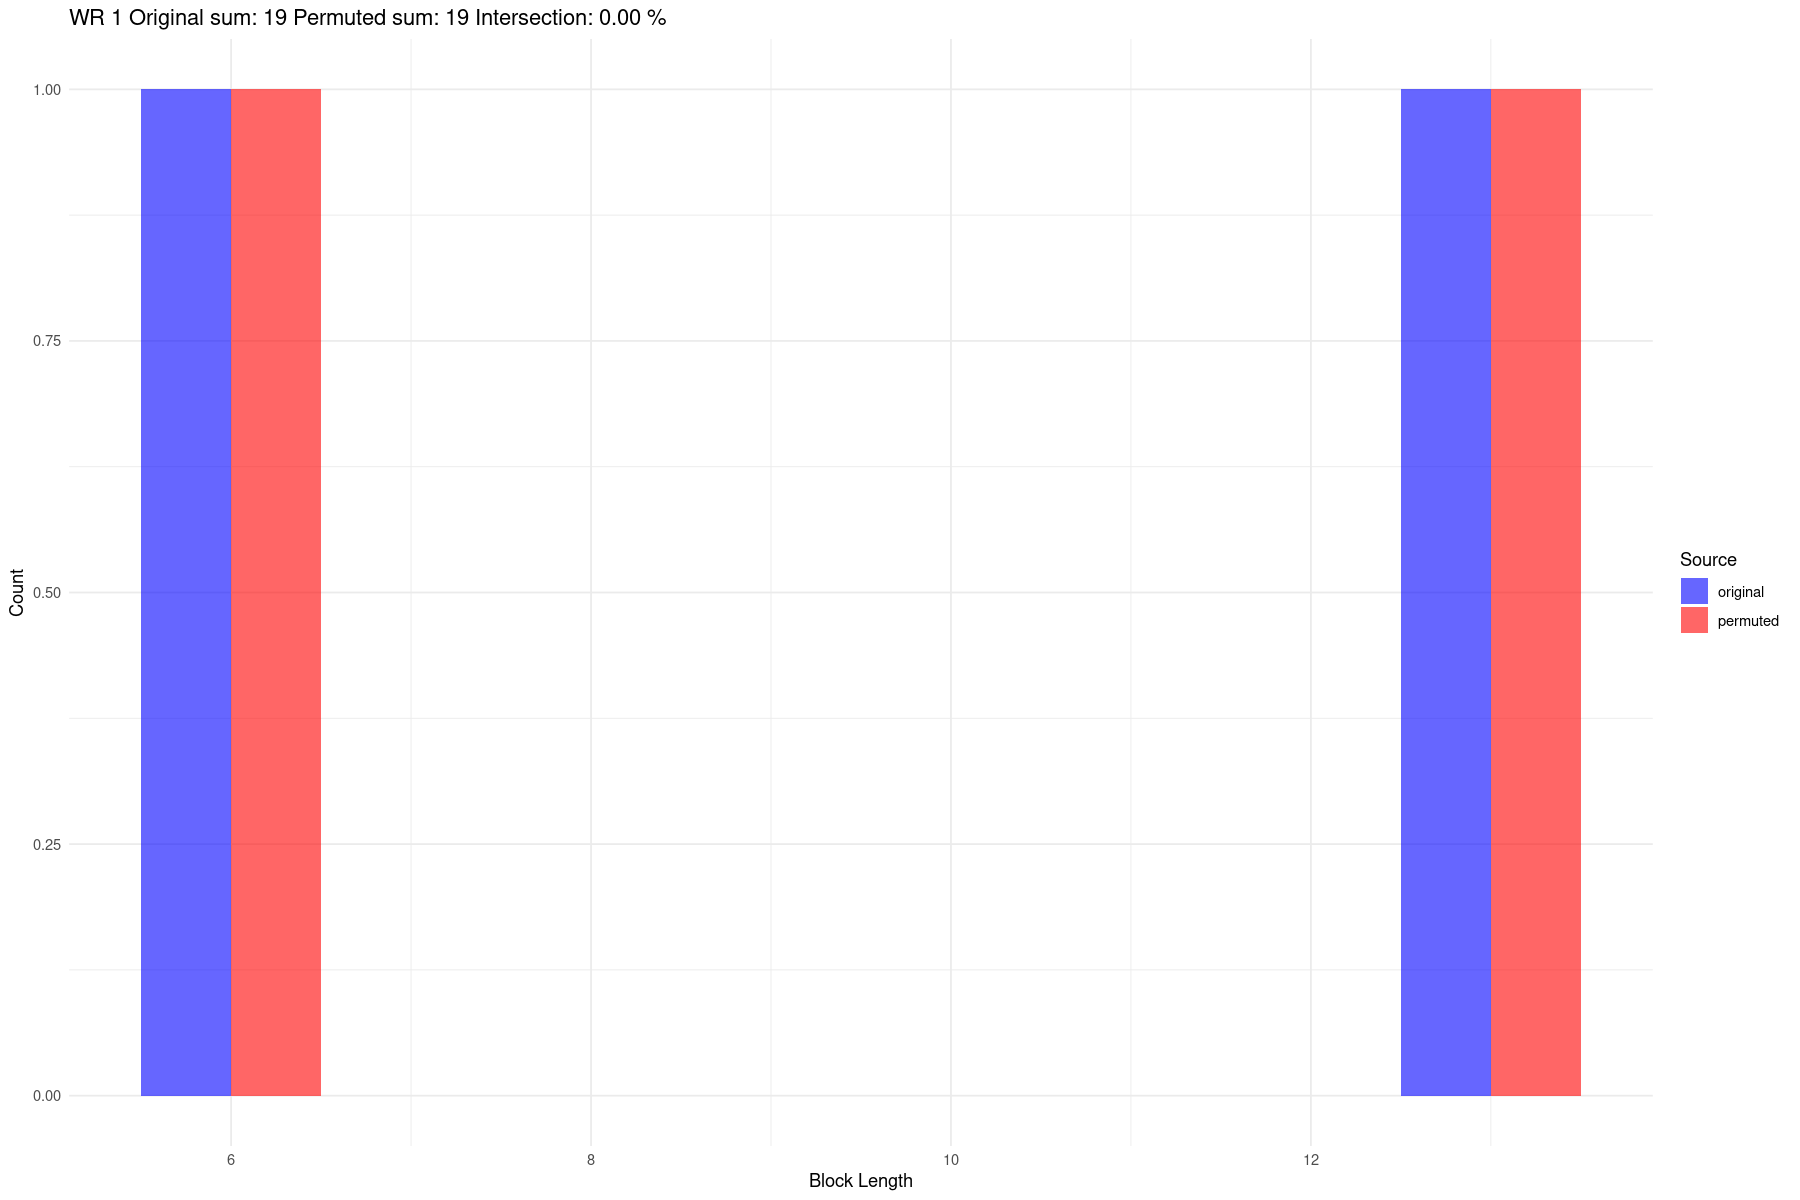

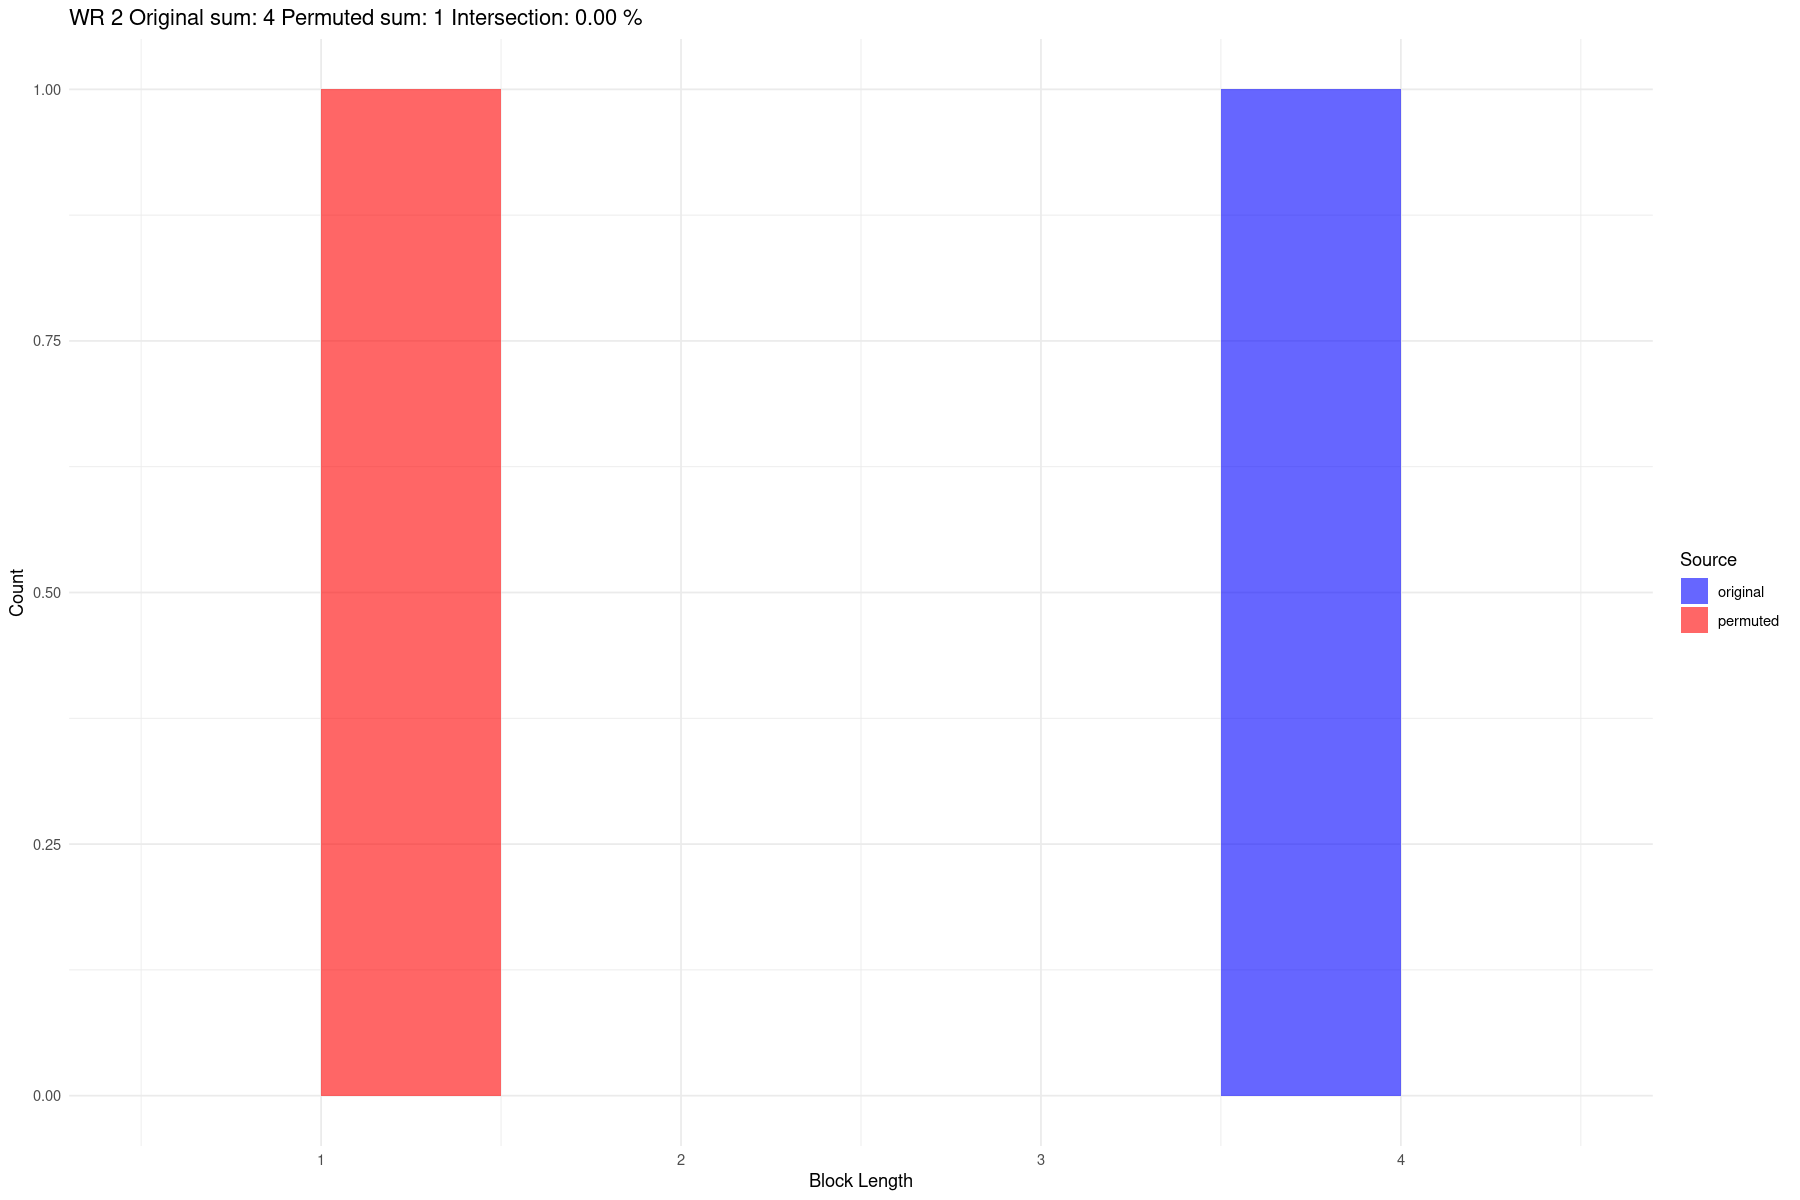

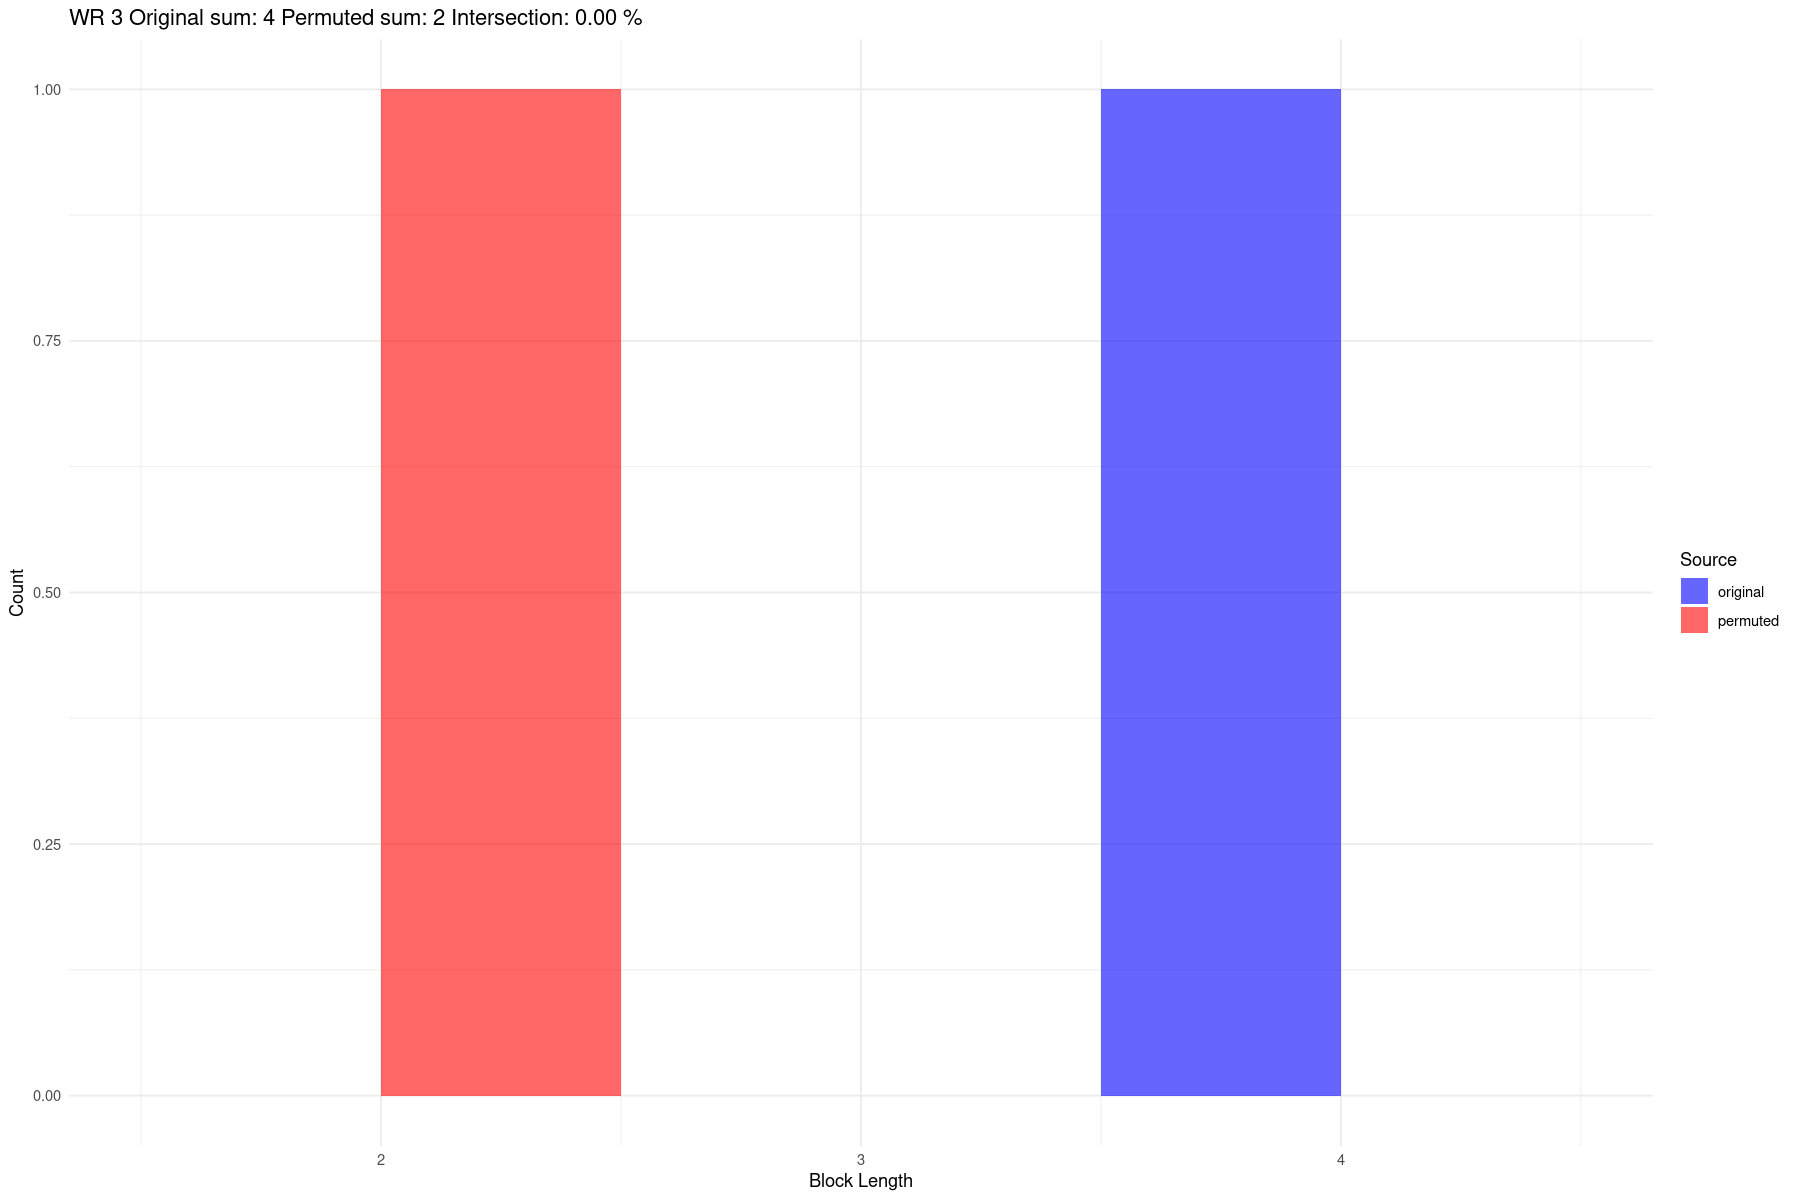

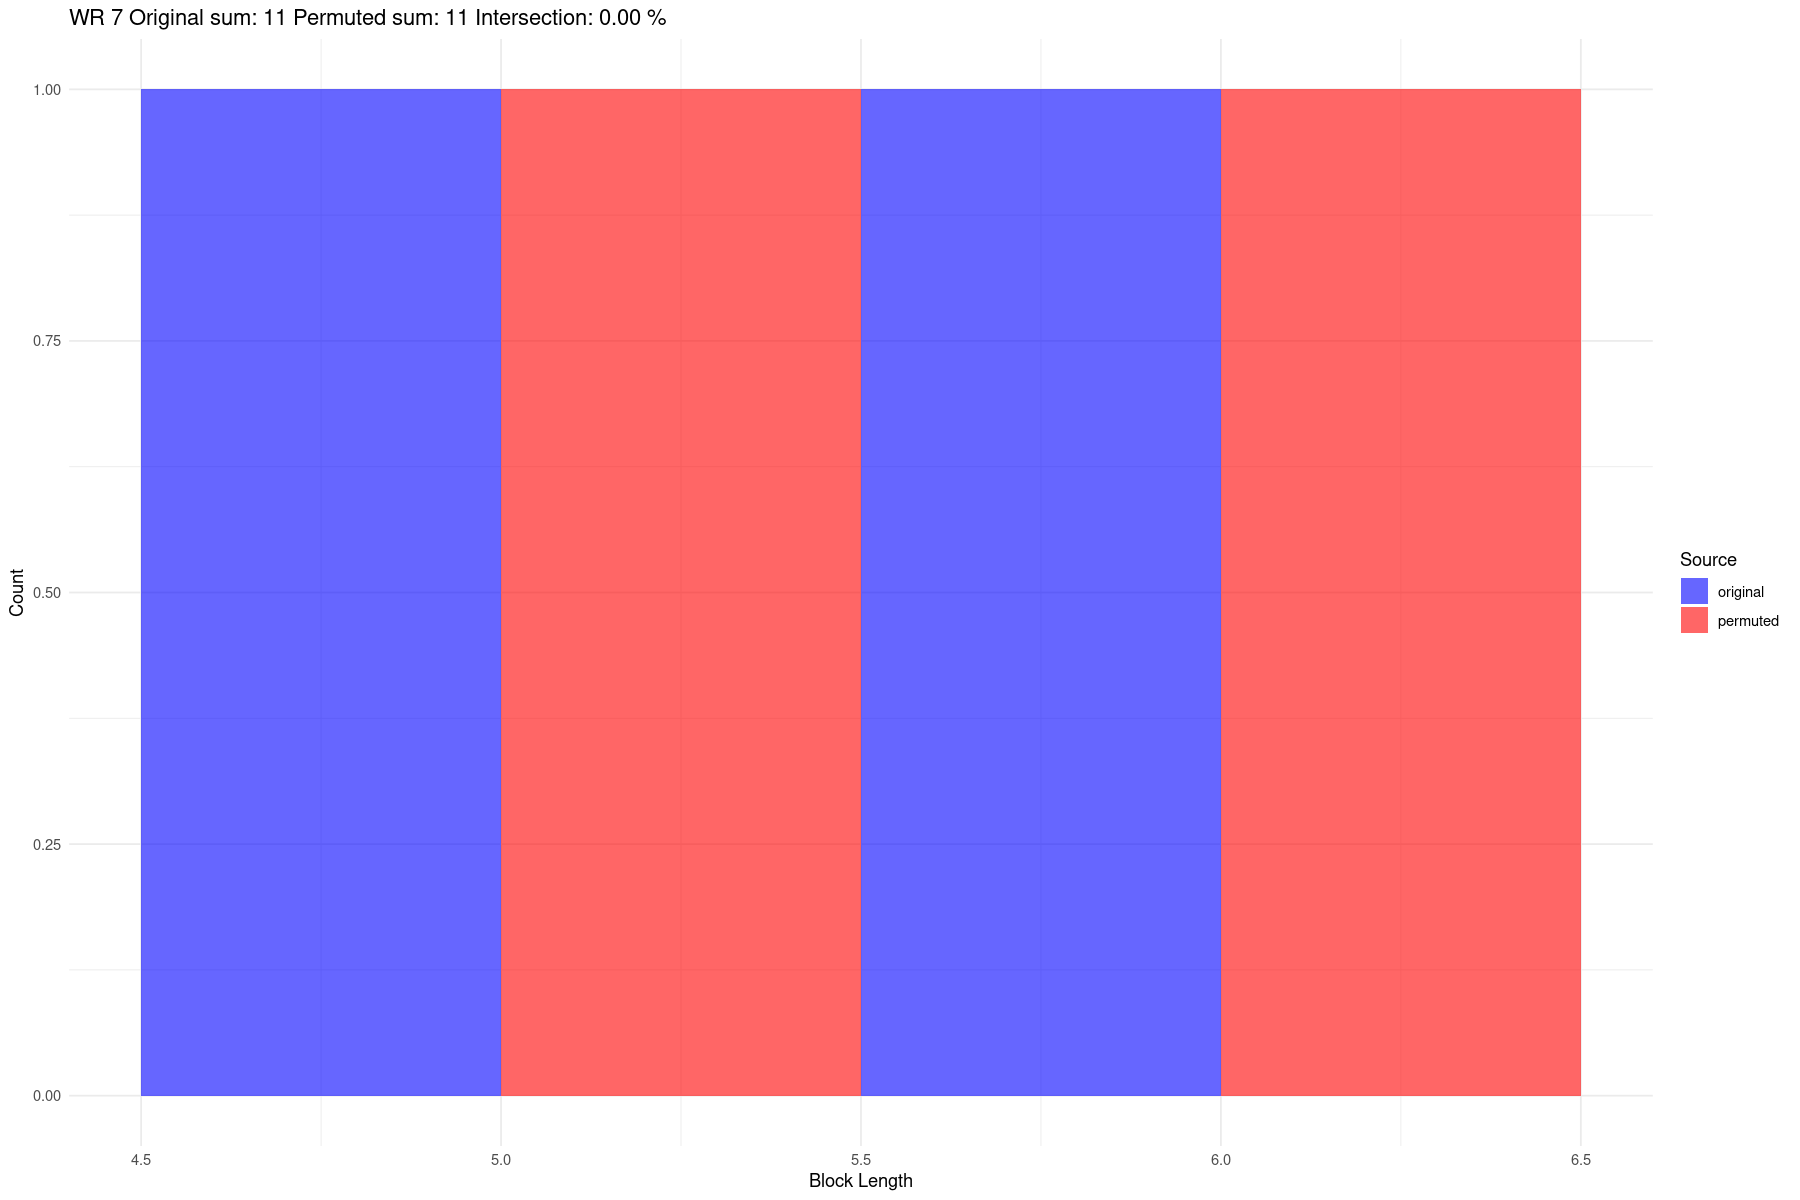

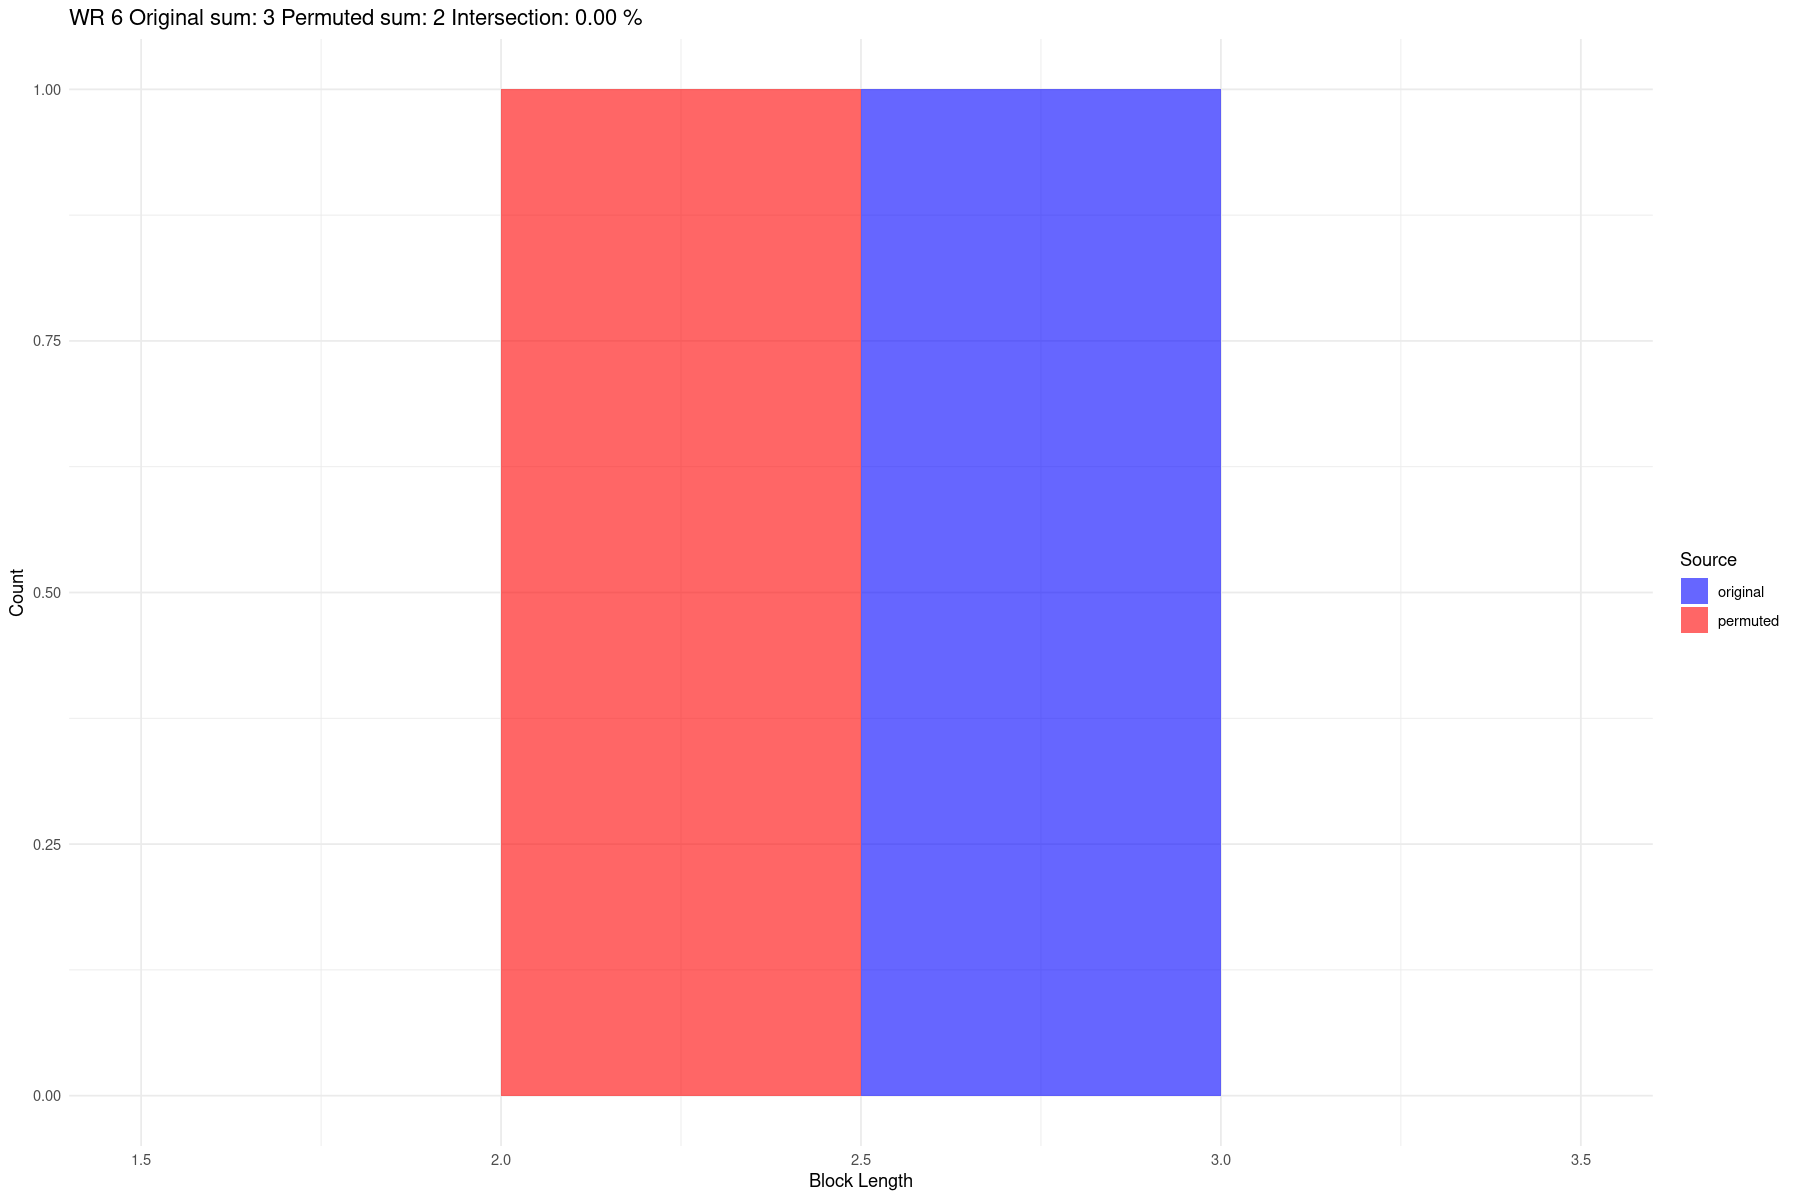

In [8]:
wr_df_short <- wr_df[1:100, ]

# Test if the above function works
for (wr in unique(wr_df_short$wrindex)) {
    actual_dates <- wr_df_short$date[wr_df_short$wrindex == wr]
    blocks <- get_run_blocks(wr_df_short$date, actual_dates)

    permuted <- permute_blocks(blocks, wr_df_short$date)
    pblocks <- get_run_blocks(wr_df_short$date, permuted)
    df <- data.frame(
        value = c(blocks, pblocks),
        group = factor(c(
            rep("original", length(blocks)),
            rep("permuted", length(pblocks))
        ))
    )

    n_both <- length(intersect(actual_dates, permuted))
    # Create the histogram
    p <- ggplot(df, aes(x = value, fill = group)) +
        geom_histogram(position = "dodge", alpha = 0.6, binwidth = 1) +
        scale_fill_manual(values = c("original" = "blue", "permuted" = "red")) +
        labs(
            title = paste0(
                "WR ", wr,
                " Original sum: ", sum(blocks),
                " Permuted sum: ", sum(pblocks),
                " Intersection: ",
                sprintf("%.2f", (n_both / length(actual_dates) * 100)),
                " %"
            ),
            x = "Block Length",
            y = "Count",
            fill = "Source"
        ) +
        theme_minimal()
    print(p)
}


In [9]:
ddf <- comp_df %>% pivot_longer(
  cols = c(p_value, p_value_adj),
  names_to = "p_type",
  values_to = "value"
)
str(ddf %>% filter(p_type == "p_value_adj", value > 1))
str(ddf %>% filter(p_type == "p_value", value > 1))


tibble [0 × 7] (S3: tbl_df/tbl/data.frame)
 $ wr    : int(0) 
 $ wrname: chr(0) 
 $ mean  : num(0) 
 $ lon   : num(0) 
 $ lat   : num(0) 
 $ p_type: chr(0) 
 $ value : num(0) 
tibble [0 × 7] (S3: tbl_df/tbl/data.frame)
 $ wr    : int(0) 
 $ wrname: chr(0) 
 $ mean  : num(0) 
 $ lon   : num(0) 
 $ lat   : num(0) 
 $ p_type: chr(0) 
 $ value : num(0) 


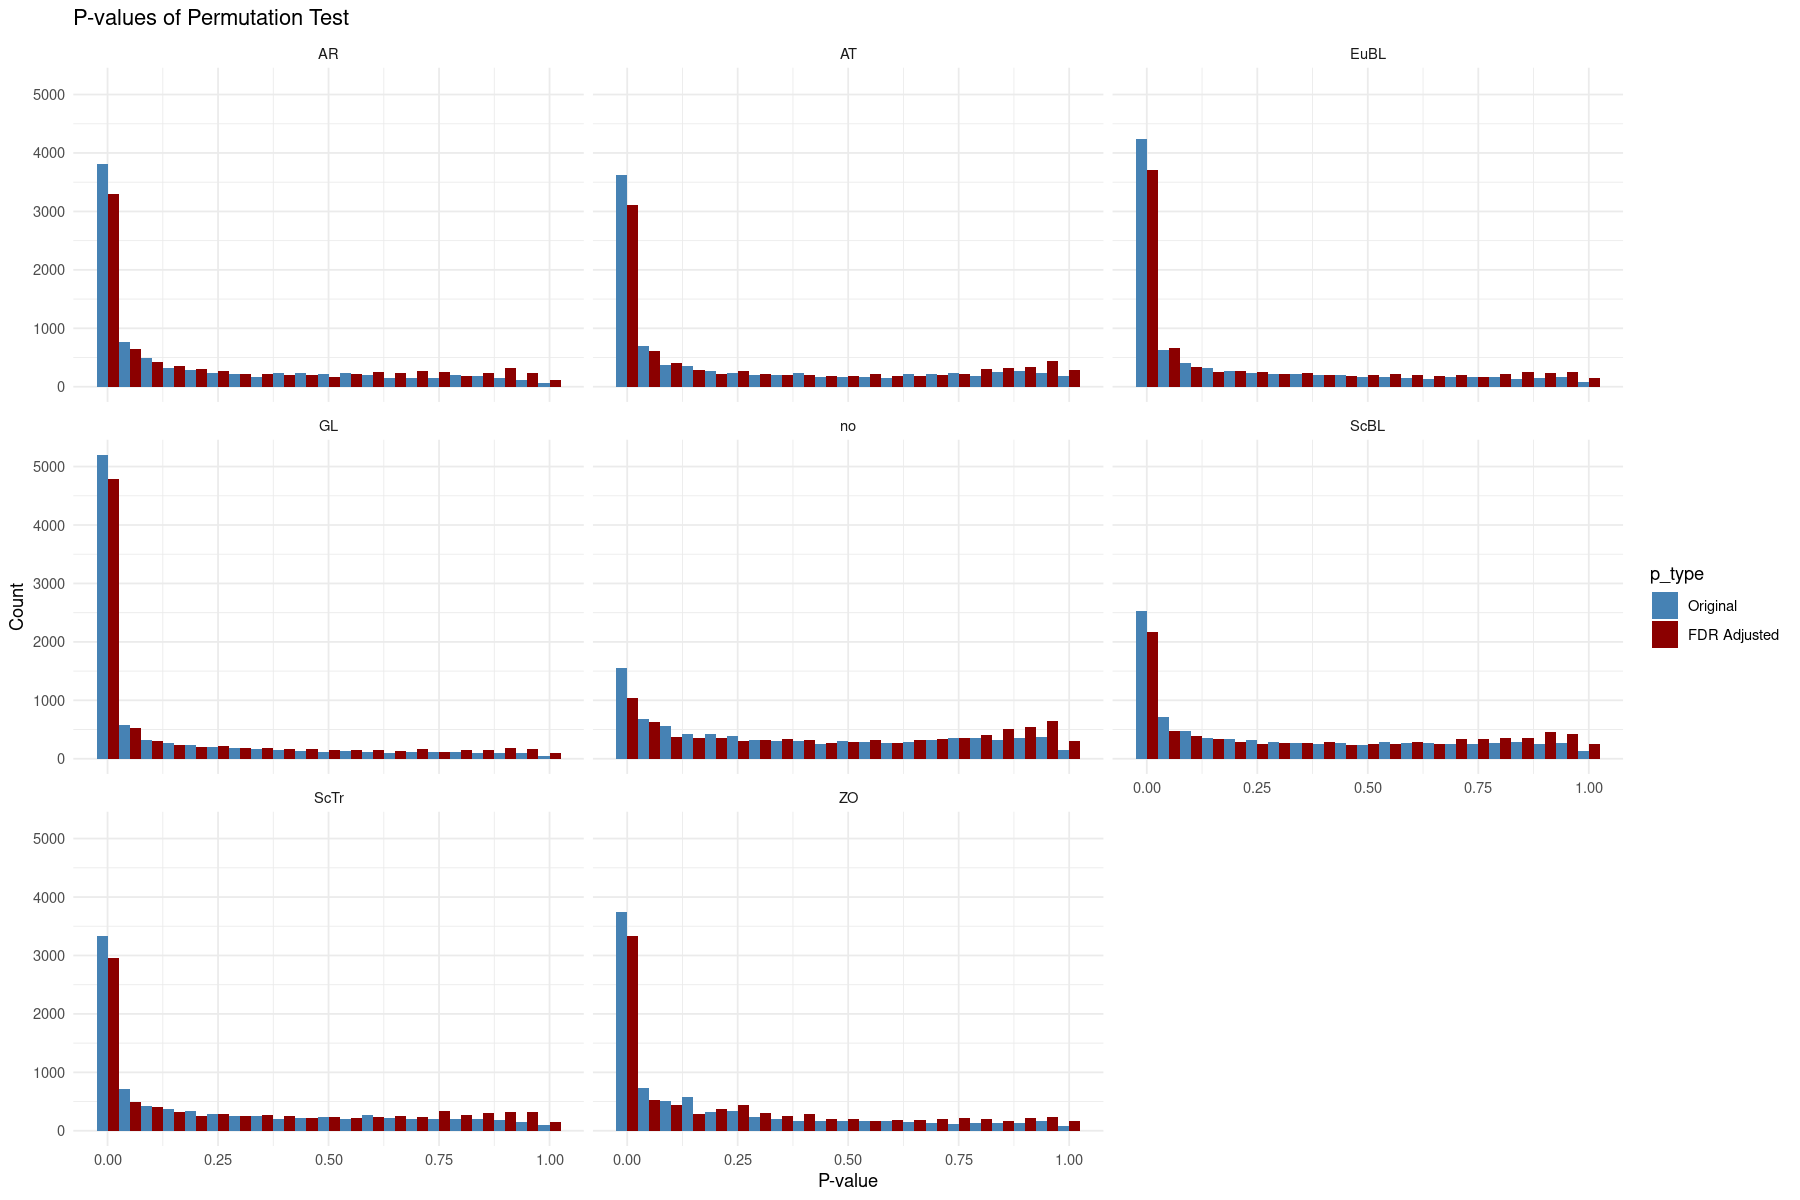

In [11]:
library(ggplot2)
comp_df %>%
  pivot_longer(
    cols = c(p_value, p_value_adj),
    names_to = "p_type",
    values_to = "value"
  ) %>%
  ggplot() +
  geom_histogram(aes(x = value, fill = p_type), binwidth = .05, position = "dodge") +
  facet_wrap(~wrname) +
  scale_fill_manual(
    values = c("p_value" = "steelblue", "p_value_adj" = "darkred"),
    labels = c("p_value" = "Original", "p_value_adj" = "FDR Adjusted")
  ) +
  labs(
    title = "P-values of Permutation Test",
    x = "P-value",
    y = "Count"
  ) +
  theme_minimal()


## TODO
- use diverging scale centered at 0
- add gh500 lines
- same scale for all?
- subplots?
- consider correct order


Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven ho

pdf 
  2

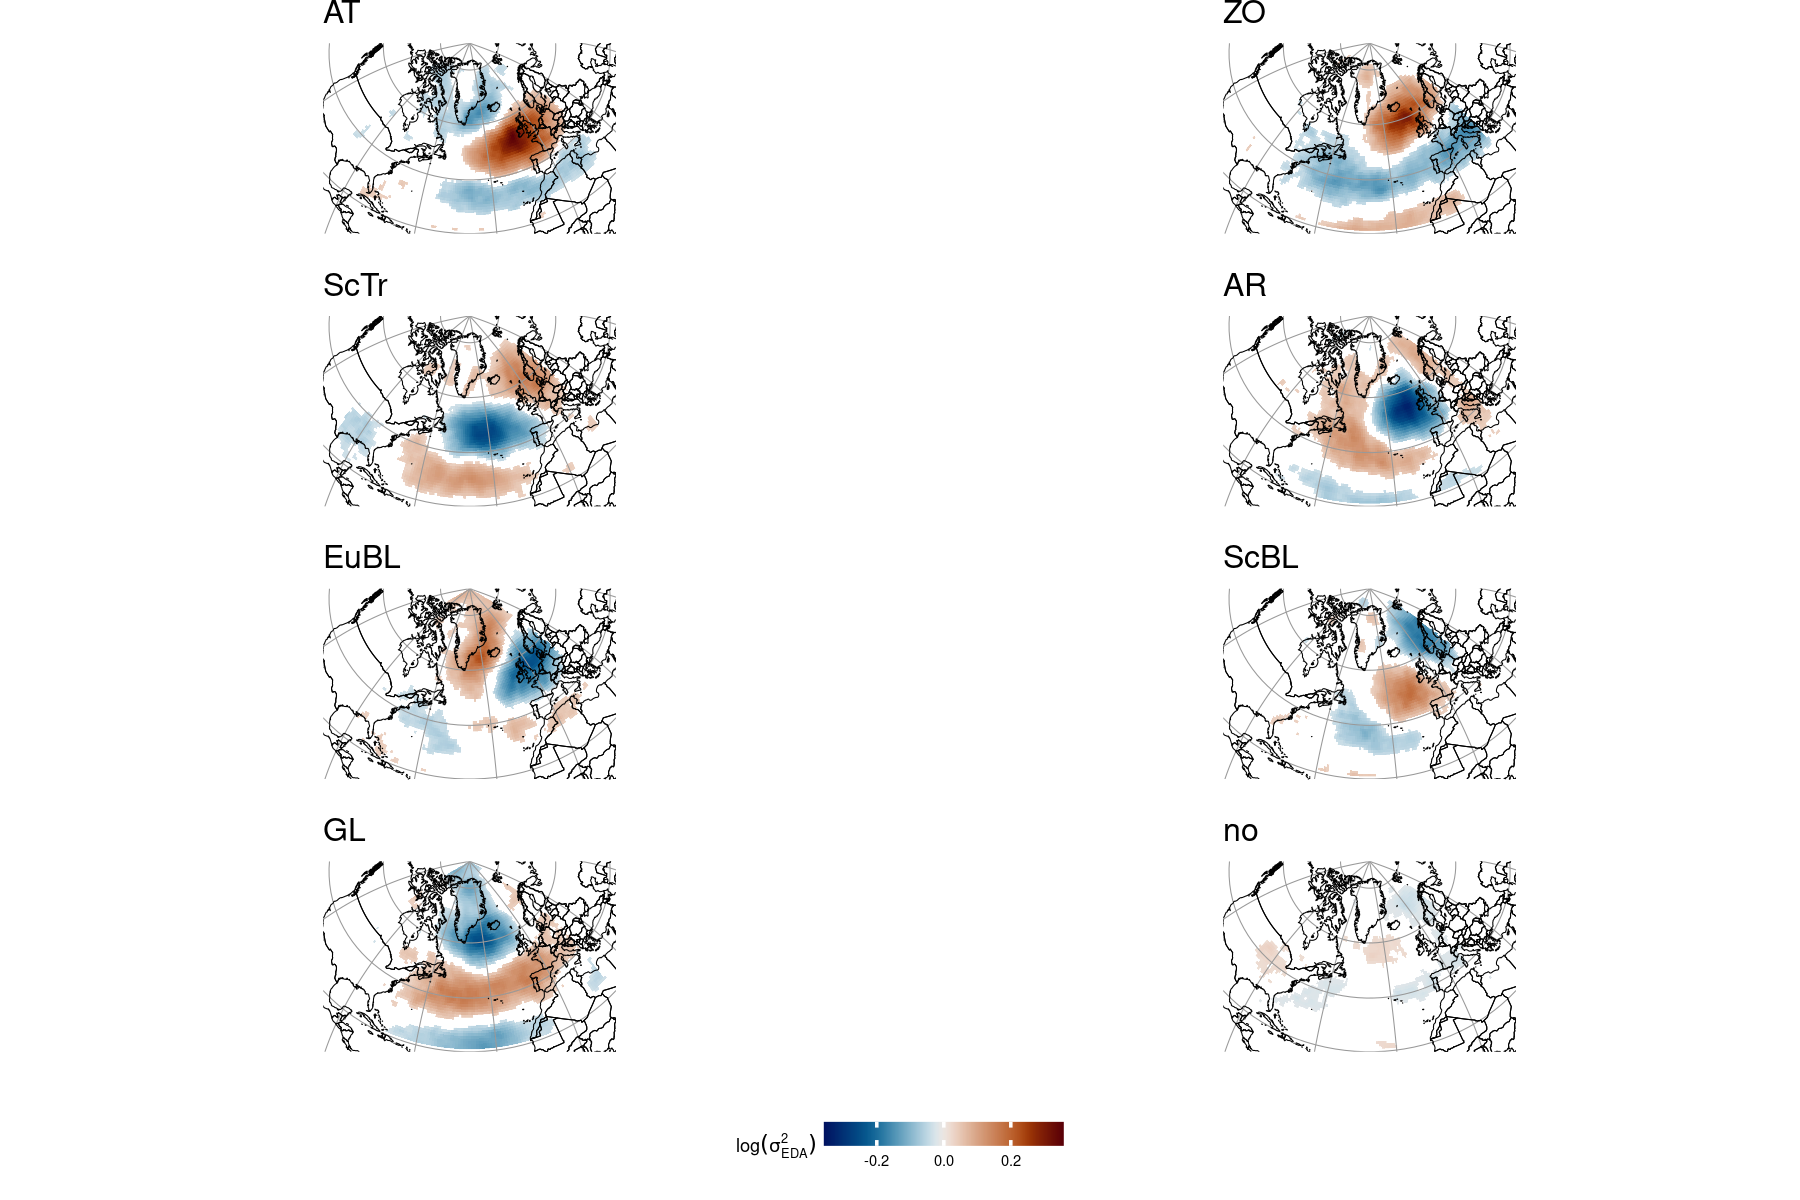

In [36]:
# Step 2: Create two plots and combine them
test_combine_two <- function() {
  # Libraries
  library(ggplot2)
  library(cowplot)
  library(sf)
  library(rnaturalearth)
  library(stars)

  plots <- list()
  i <- 1
  for (wri in c(1, 6, 7, 2, 4, 5, 3, 0)) {
    wrn <- comp_df$wrname[comp_df$wr == wri][1]
    wr_df_i <- comp_df %>%
      filter(wr == wri)
    # Plotting the mean
    plots[[i]] <- plot_spatial(wr_df_i, "mean",
      legend_name = "$\\log(\\sigma^{2}_{EDA})$",
      sig_name = "p_value_adj",
      alpha = .05,
      show_graticule_labels = FALSE,
      use_diverging = TRUE,
      clims = c(-.357, 0.357)
    ) + THEME_PUB_LARGE +
      theme(
        axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks = element_blank(),
        legend.position = "none",
        plot.margin = margin(0, 0, 0, 0),
        panel.spacing = unit(0, "lines")
      ) + labs(title = wrn)
    i <- i + 1
  }

  # Get legend from one plot with legend
  p_legend <- plot_spatial(wr_df_i, "mean",
    legend_name = "$\\log(\\sigma^{2}_{EDA})$",
    sig_name = "p_value_adj",
    alpha = .05,
    show_graticule_labels = FALSE,
    use_diverging = TRUE,
    clims = c(-.357, 0.357)
  ) + theme(legend.position = "bottom")
  # Extract just the legend grob
  legend_grob <- ggplotGrob(
    p_legend
  )$grobs[[which(sapply(
    ggplotGrob(p_legend)$grobs,
    function(x) x$name
  ) == "guide-box")]]

  # Manually create a new plot containing just the legend
  legend_plot <- ggplot() +
    annotation_custom(legend_grob) +
    theme_void()

  # Combine plots
  combined <- plot_grid(plotlist = plots, ncol = 2)
  final <- plot_grid(combined, legend_plot, ncol = 1, rel_heights = c(1, 0.1), greedy = TRUE)

  # Print to see if it works
  return(final)
}
p <- test_combine_two()
print(p)
save_plot(p, "RegimesLarge.pdf", width = 4, height = 8)


## To add the WR gh500 contours
- calculate composites since CG is not responding

In [ ]:
# Get the z_control data
# Open the file
nc <- nc_open("../ens_data/data.nc")

# Identify the index for number == 0
num <- ncvar_get(nc, "number")
number_idx <- which(num == 0)
# Use the first occurrence (modify if needed)
number_idx <- number_idx[1]
# Find indices for the desired year
time_data <- ncvar_get(nc, "valid_time")
time_origin <- sub(
    "seconds since ", "",
    ncatt_get(nc, "valid_time", "units")$value
)
time_whole <- as.Date(as.POSIXct(time_data,
    origin = time_origin,
    tz = "UTC"
))

start_vec <- c(1, 1, 1, number_idx)
count_vec <- c(-1, -1, -1, 1)
z_control <- ncvar_get(nc, "z", start = start_vec, count = count_vec)

nc_close(nc)

str(z_control)


In [ ]:
# Function to calculate weather regime composites
calculate_wr_composites <- function(z_data, z_dates, wr_data) {
    # Find the overlapping date range
    min_z_date <- min(z_dates)
    max_z_date <- max(z_dates)

    cat(sprintf("Z data date range: %s to %s\n", min_z_date, max_z_date))
    cat(sprintf("WR data date range: %s to %s\n", min(wr_data$date), max(wr_data$date)))

    # Filter wr_data to only include dates within the z_data range
    wr_data_filtered <- wr_data[date >= min_z_date & date <= max_z_date]

    cat(sprintf(
        "Number of dates in WR data within Z data range: %d (out of %d)\n",
        nrow(wr_data_filtered), nrow(wr_data)
    ))

    # Create a mapping between dates and their position in the z_data
    date_lookup <- data.table(
        date = z_dates,
        time_idx = 1:length(z_dates)
    )

    # Merge to find matching indices
    merged <- merge(wr_data_filtered, date_lookup, by = "date", all.x = FALSE)

    # Check if there are any dates in wr_data that don't match z_dates
    if (nrow(merged) < nrow(wr_data_filtered)) {
        warning(sprintf(
            "%d dates in filtered WR data do not match any date in Z data",
            nrow(wr_data_filtered) - nrow(merged)
        ))
    }

    # Get unique regime indices and names
    regimes <- unique(wr_data[, .(wrindex, wrname)])

    # Initialize list to store composites
    composites <- list()

    # Calculate composite for each weather regime
    for (i in 1:nrow(regimes)) {
        regime_idx <- regimes$wrindex[i]
        regime_name <- regimes$wrname[i]

        # Find all time indices for this regime
        regime_matches <- merged[wrindex == regime_idx]
        time_indices <- regime_matches$time_idx

        if (length(time_indices) > 0) {
            # Calculate composite (mean across time dimension)
            # Assuming z_data dimensions are [lon, lat, time]
            regime_composite <- apply(z_data[, , time_indices, drop = FALSE],
                c(1, 2), mean,
                na.rm = TRUE
            )

            # Store in list
            composites[[regime_name]] <- list(
                data = regime_composite,
                n_days = length(time_indices),
                indices = time_indices,
                dates = regime_matches$date
            )

            cat(sprintf(
                "Regime %s (%d): Composite calculated using %d days\n",
                regime_name, regime_idx, length(time_indices)
            ))
        } else {
            warning(sprintf("No matching dates found for regime %s (%d)", regime_name, regime_idx))
        }
    }

    # Return list of composites
    return(composites)
}

control_comp <- calculate_wr_composites(
    z_data = z_control,
    z_dates = time_whole,
    wr_data = wr_df
)
